<a href="https://www.kaggle.com/code/sineths/pr-cnn-syp?scriptVersionId=271438983" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        continue
print('DONE')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DONE


In [2]:
#importing required libraries for the job

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import os

In [3]:
 # Check if any GPU is available
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 # If a CUDA device is available, use the first available GPU
 if torch.cuda.is_available():
  device = torch.device("cuda:0")  # Using the first available GPU at index 0
 else:
  device = torch.device("cpu")
 print(f"Using device: {device}")

Using device: cuda:0


In [4]:
#Loading the dataset from drive
dataset_path = '/kaggle/input/realwaste/realwaste-main/RealWaste'

In [5]:
global IMAGE_SIZE, BATCH_SIZE, CHANNELS, NUM_CLASSES, EPOCH
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCH = 150

In [6]:

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Making sure that the size is fixed for all
    transforms.ToTensor(), # Convert to tensor
])

#Load dataset from directory
dataset = ImageFolder(root=dataset_path, transform=transform)


In [7]:
CLASSES = dataset.classes
NUM_CLASSES = len(CLASSES)
print(NUM_CLASSES)

# View class names (subfolder names)
print("Class Names:")
for class_name in dataset.classes:
    print(class_name)


# View class-to-index mapping
print("\nClass-to-Index Mapping:")
for class_name, index in dataset.class_to_idx.items():
    print(f"{index}: {class_name}")

# View total number of samples
print("\nNumber of images:", len(dataset))

# View a single sample (image and label)
img1, label1 = dataset[0]  # Access the first sample
print("Image shape:", img1.shape)  # Shape of the image tensor
print("Label:", label1)  # Integer label corresponding to the class

9
Class Names:
Cardboard
Food Organics
Glass
Metal
Miscellaneous Trash
Paper
Plastic
Textile Trash
Vegetation

Class-to-Index Mapping:
0: Cardboard
1: Food Organics
2: Glass
3: Metal
4: Miscellaneous Trash
5: Paper
6: Plastic
7: Textile Trash
8: Vegetation

Number of images: 4752
Image shape: torch.Size([3, 256, 256])
Label: 0


In [8]:
#splitting the dataset into 70% , 15% and 15% for train, test and valid (as mentioned)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for validation and test sets

#seed for reproducibility
torch.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )
# seed for reproducibility
torch.manual_seed(42)
valid_loader = DataLoader(valid_dataset, batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )


# seed for reproducibility
torch.manual_seed(42)
test_loader = DataLoader(test_dataset,  batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )

In [9]:
# Check the size of SETS
print(f"Training set size: {len(train_loader)}")
print(f"Validation set size: {len(valid_loader)}")
print(f"Test set size: {len(test_loader)}")

Training set size: 208
Validation set size: 45
Test set size: 45


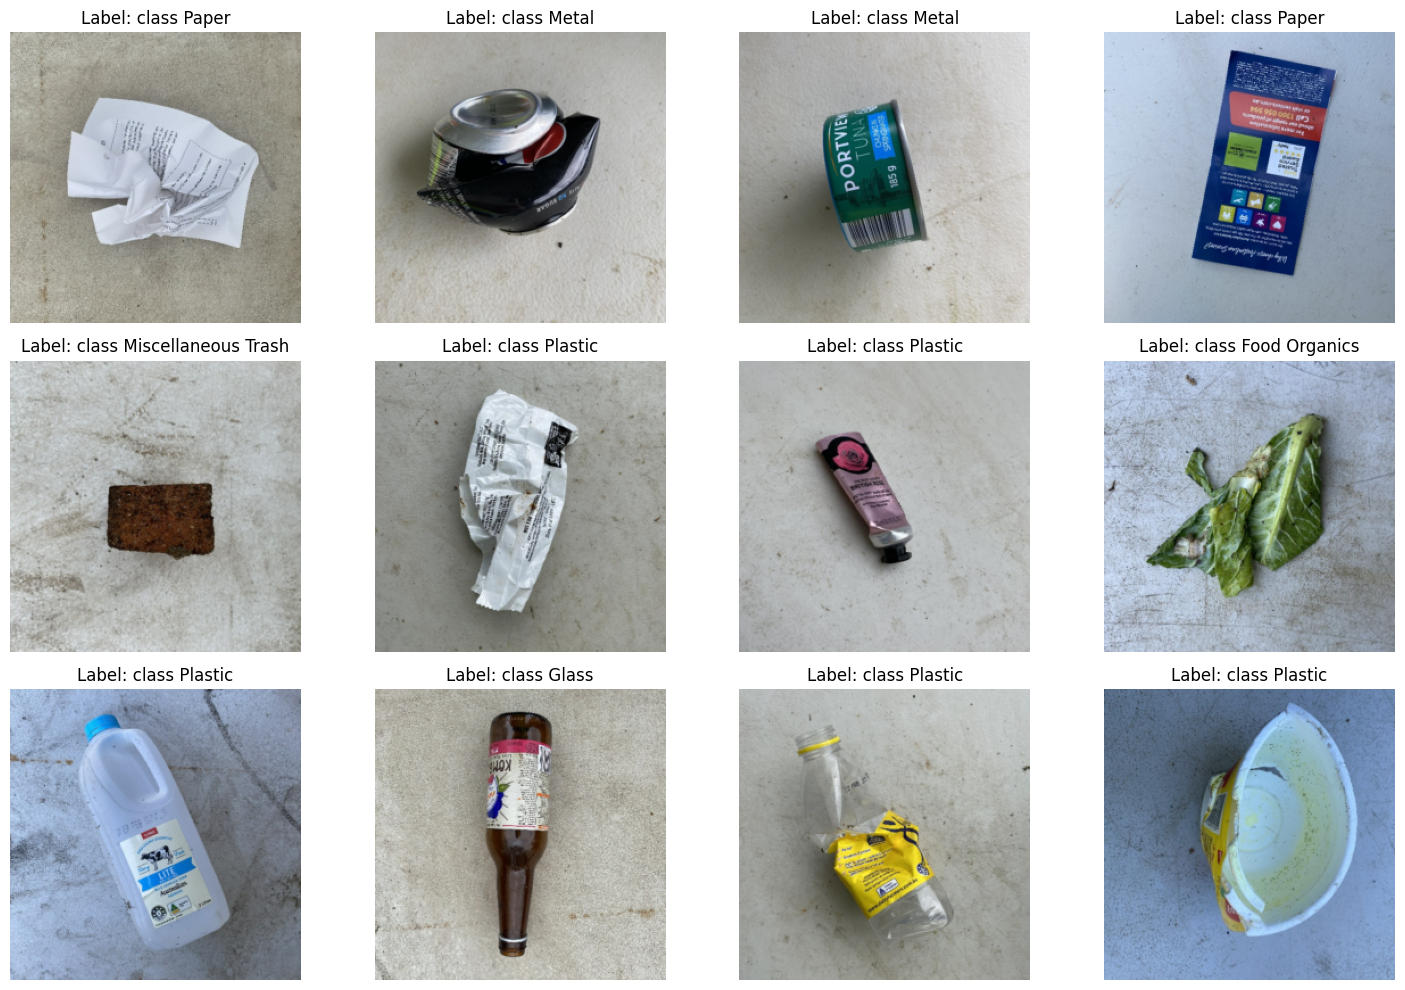

In [10]:
#for a singular image
for images, labels in train_loader:
  fig, axes = plt.subplots(3, 4, figsize=(15, 10))

  # Plot the first 12 images
  for i in range(12):
      row, col = divmod(i, 4)
      ax = axes[row, col]
      ax.imshow(images[i].permute(1, 2, 0))  # Change from C x H x W to H x W x C)
      ax.set_title(f"Label: class {CLASSES[labels[i].item()]}") #display class name
      ax.axis('off')  # Turn off axes

  plt.tight_layout()
  plt.show()
  break


In [11]:
# =====================================================
# Defining the CNN following the provided architecture description!!!
# =====================================================
class SimpleWasteCNN(nn.Module):
    def __init__(self, num_classes, x1=32, m1=3, x2=64, m2=3, x3=128, d=0.5, negative_slope=0.01):
        super(SimpleWasteCNN, self).__init__()

        # Conv1: m1×m1 kernel
        self.conv1 = nn.Conv2d(3, x1, kernel_size=m1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Conv2: m2×m2 kernel
        self.conv2 = nn.Conv2d(x1, x2, kernel_size=m2, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        # Input: x2 * 64 * 64 (for 256x256 input after 2 pooling layers)
        self.fc1 = nn.Linear(x2 * 64 * 64, x3)
        self.dropout = nn.Dropout(p=d)
        self.fc2 = nn.Linear(x3, num_classes)

        # LeakyReLU activation
        self.leaky_relu = nn.LeakyReLU(negative_slope=negative_slope)

    def forward(self, x):
        # Convolution + Activation + Pooling (Layer 1)
        x = self.leaky_relu(self.conv1(x))
        x = self.pool1(x)

        # Convolution + Activation + Pooling (Layer 2)
        x = self.leaky_relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected + Dropout
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)

        # Output layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [12]:
# =====================================================
# A deeper and more complex CNN: BigWasteCNN
# =====================================================
class BigWasteCNN(nn.Module):
    def __init__(self, num_classes):
        super(BigWasteCNN, self).__init__()
        negative_slope=0.01
        #Convolutional feature extractor
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.MaxPool2d(2, 2),   # 256 → 128

            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.MaxPool2d(2, 2),   # 128 → 64

            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.MaxPool2d(2, 2),   # 64 → 32

            # Block 4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.MaxPool2d(2, 2),   # 32 → 16

            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.MaxPool2d(2, 2),   # 16 → 8
        )

        # ----- Fully connected head -----
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1024),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


Initially we will run with 20 epochs as mentioned to see how everything works

In [13]:
# =====================================================
# Training function for the models with configurable momentum
# =====================================================

def train_model(model_class, train_loader, val_loader, num_classes,
                optimizer_name='adam', learning_rate=0.001, momentum=0.9, 
                num_epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu', name = None):
    
    # If model_class is already an instance, use it directly
    if isinstance(model_class, torch.nn.Module):
        model = model_class.to(device)
    else:
        model = model_class(num_classes=num_classes).to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # =====================================================
    # Optimizer selection (momentum configurable)
    # =====================================================
    if optimizer_name.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # No momentum
    elif optimizer_name.lower() == 'sgd_momentum':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    else:
        raise ValueError("Optimizer must be 'adam', 'sgd', or 'sgd_momentum'.")

    # Lists for metrics
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    # =====================================================
    # Training loop
    # =====================================================
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total

        # =====================================================
        # Validation loop
        # =====================================================
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        # Record metrics
        train_loss.append(epoch_train_loss)
        val_loss.append(epoch_val_loss)
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

    # =====================================================
    # Save model
    # =====================================================
    save_dir = "/kaggle/working/"
    model_filename = f"{name}_{optimizer_name}_{num_epochs}.pth"
    model_path = os.path.join(save_dir, model_filename)
    torch.save(model.state_dict(), model_path)
    print(f"\n Model saved at: {model_path}!")

    # =====================================================
    # Save metrics as CSV
    # =====================================================
    results_df = pd.DataFrame({
        'epoch': list(range(1, num_epochs + 1)),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    })
    csv_filename = f"results_{optimizer_name}_{num_epochs}.csv"
    csv_path = os.path.join(save_dir, csv_filename)
    results_df.to_csv(csv_path, index=False)
    print(f" Results saved as CSV at: {csv_path}!")

    # =====================================================
    # Plot Loss and Accuracy
    # =====================================================
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{optimizer_name.upper()} - Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{optimizer_name.upper()} - Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return {
        'optimizer': optimizer_name,
        'momentum': momentum if 'momentum' in optimizer_name else None,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    }


In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

def evaluate_model(model, dataloader, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):

    model.eval()
    model.to(device)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # === Compute Metrics ===
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    conf_mat = confusion_matrix(all_labels, all_preds)

    # === Print and Plot ===
    print("\n=== Evaluation Results ===")
    print(f"Test Accuracy: {acc*100:.2f}%")
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # === Return key metrics ===
    return {
        "accuracy": acc,
        "precision": {cls: report[cls]["precision"] for cls in class_names},
        "recall": {cls: report[cls]["recall"] for cls in class_names},
        "f1": {cls: report[cls]["f1-score"] for cls in class_names},
        "confusion_matrix": conf_mat
    }


Epoch [1/20] | Train Loss: 1.9344 | Val Loss: 1.5559 | Train Acc: 28.95% | Val Acc: 43.96%
Epoch [2/20] | Train Loss: 1.5151 | Val Loss: 1.3350 | Train Acc: 46.78% | Val Acc: 50.56%
Epoch [3/20] | Train Loss: 1.3125 | Val Loss: 1.1957 | Train Acc: 53.97% | Val Acc: 56.32%
Epoch [4/20] | Train Loss: 1.1379 | Val Loss: 1.1613 | Train Acc: 60.25% | Val Acc: 58.29%
Epoch [5/20] | Train Loss: 1.0088 | Val Loss: 1.0497 | Train Acc: 64.64% | Val Acc: 63.34%
Epoch [6/20] | Train Loss: 0.9066 | Val Loss: 1.0538 | Train Acc: 69.81% | Val Acc: 63.20%
Epoch [7/20] | Train Loss: 0.8193 | Val Loss: 0.9930 | Train Acc: 72.01% | Val Acc: 63.62%
Epoch [8/20] | Train Loss: 0.7342 | Val Loss: 0.9800 | Train Acc: 74.86% | Val Acc: 63.90%
Epoch [9/20] | Train Loss: 0.6603 | Val Loss: 0.9431 | Train Acc: 77.39% | Val Acc: 65.59%
Epoch [10/20] | Train Loss: 0.5791 | Val Loss: 1.0115 | Train Acc: 80.70% | Val Acc: 66.15%
Epoch [11/20] | Train Loss: 0.4994 | Val Loss: 0.9859 | Train Acc: 82.80% | Val Acc: 66.0

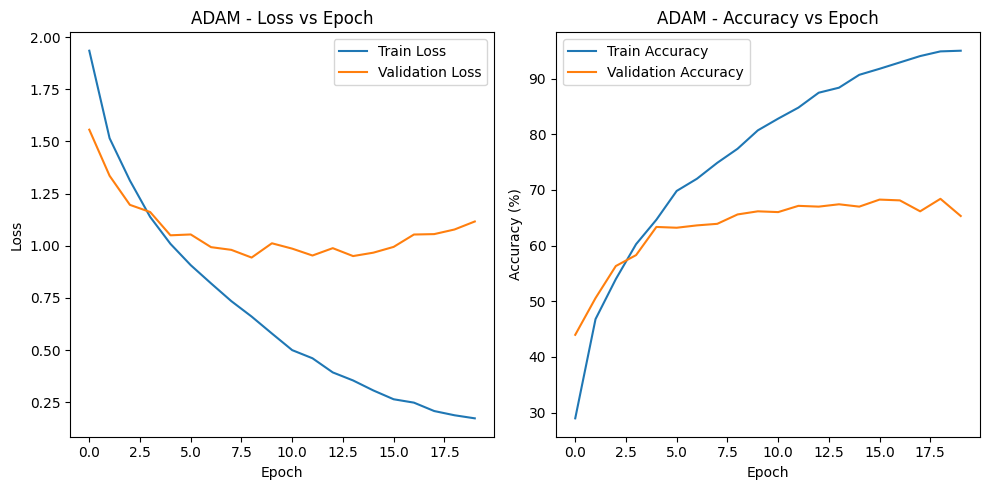


=== Evaluation Results ===
Test Accuracy: 69.61%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.62      0.66      0.64        68
      Food Organics       0.83      0.79      0.81        62
              Glass       0.86      0.79      0.83        63
              Metal       0.71      0.69      0.70       112
Miscellaneous Trash       0.58      0.30      0.39        71
              Paper       0.73      0.70      0.71        79
            Plastic       0.63      0.77      0.69       133
      Textile Trash       0.54      0.58      0.56        60
         Vegetation       0.80      0.95      0.87        66

           accuracy                           0.70       714
          macro avg       0.70      0.69      0.69       714
       weighted avg       0.69      0.70      0.69       714



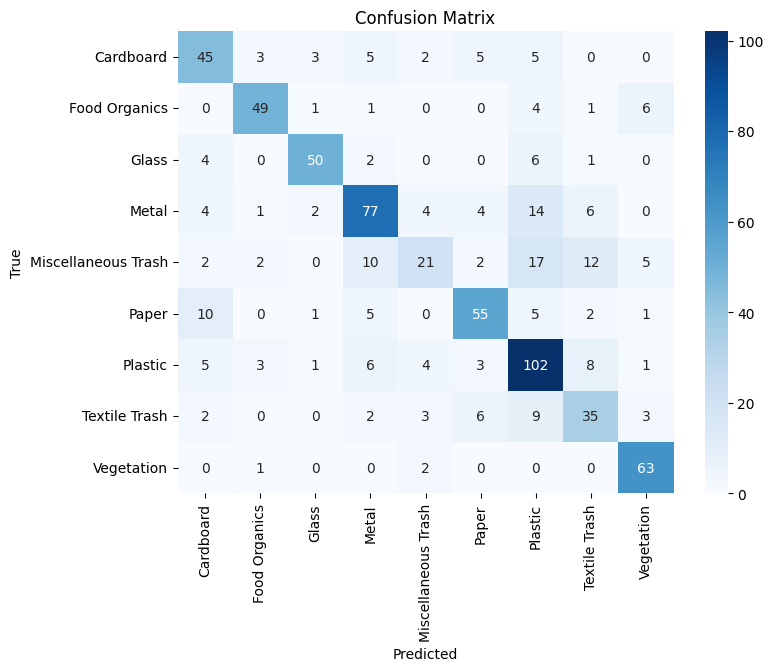

In [15]:
#Here we are using adam optimizer to ge the best to evertything an optimzer could give and a rate of 0.004, a moderate value
simple_waste = SimpleWasteCNN(num_classes=NUM_CLASSES).to(device)

results = train_model(simple_waste, train_loader, valid_loader, num_classes=NUM_CLASSES, optimizer_name="adam", learning_rate=0.0001, name = "simplewaste")
metrics = evaluate_model( model=simple_waste, dataloader=test_loader, class_names=CLASSES)



===== Training with ADAM =====
Epoch [1/20] | Train Loss: 2.0574 | Val Loss: 1.8476 | Train Acc: 25.77% | Val Acc: 33.29%
Epoch [2/20] | Train Loss: 1.6595 | Val Loss: 1.4544 | Train Acc: 41.07% | Val Acc: 46.91%
Epoch [3/20] | Train Loss: 1.4322 | Val Loss: 1.3314 | Train Acc: 50.03% | Val Acc: 54.35%
Epoch [4/20] | Train Loss: 1.2355 | Val Loss: 1.2678 | Train Acc: 57.34% | Val Acc: 54.49%
Epoch [5/20] | Train Loss: 1.1116 | Val Loss: 1.1252 | Train Acc: 60.67% | Val Acc: 59.97%
Epoch [6/20] | Train Loss: 1.0109 | Val Loss: 1.0641 | Train Acc: 63.92% | Val Acc: 60.25%
Epoch [7/20] | Train Loss: 0.8863 | Val Loss: 1.0843 | Train Acc: 69.09% | Val Acc: 59.83%
Epoch [8/20] | Train Loss: 0.7932 | Val Loss: 0.9887 | Train Acc: 72.37% | Val Acc: 65.31%
Epoch [9/20] | Train Loss: 0.6983 | Val Loss: 1.0462 | Train Acc: 75.44% | Val Acc: 62.92%
Epoch [10/20] | Train Loss: 0.6343 | Val Loss: 0.9265 | Train Acc: 78.53% | Val Acc: 67.13%
Epoch [11/20] | Train Loss: 0.5729 | Val Loss: 0.9622 | T

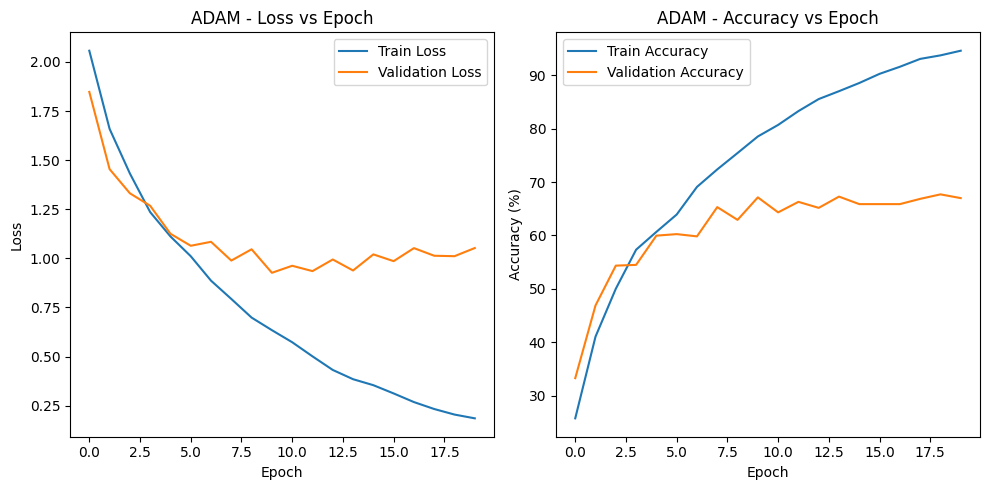


=== Evaluation Results ===
Test Accuracy: 72.55%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.71      0.66      0.69        68
      Food Organics       0.85      0.81      0.83        62
              Glass       0.89      0.75      0.81        63
              Metal       0.74      0.76      0.75       112
Miscellaneous Trash       0.58      0.45      0.51        71
              Paper       0.73      0.78      0.76        79
            Plastic       0.66      0.76      0.70       133
      Textile Trash       0.60      0.62      0.61        60
         Vegetation       0.87      0.89      0.88        66

           accuracy                           0.73       714
          macro avg       0.74      0.72      0.73       714
       weighted avg       0.73      0.73      0.72       714



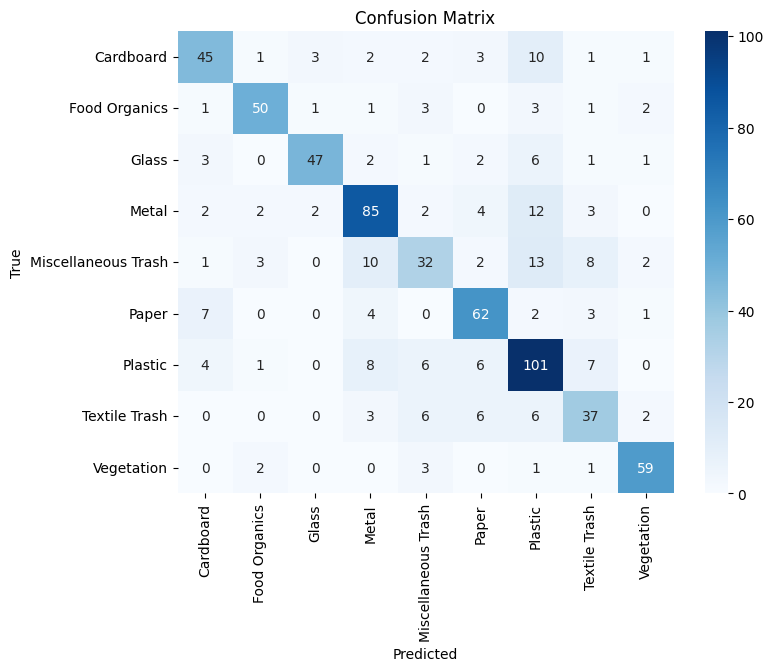


===== Training with SGD =====
Epoch [1/20] | Train Loss: 2.1601 | Val Loss: 2.1468 | Train Acc: 18.16% | Val Acc: 19.94%
Epoch [2/20] | Train Loss: 2.1439 | Val Loss: 2.1265 | Train Acc: 19.12% | Val Acc: 19.94%
Epoch [3/20] | Train Loss: 2.1188 | Val Loss: 2.0856 | Train Acc: 19.27% | Val Acc: 19.80%
Epoch [4/20] | Train Loss: 2.0911 | Val Loss: 2.0538 | Train Acc: 19.99% | Val Acc: 24.02%
Epoch [5/20] | Train Loss: 2.0638 | Val Loss: 2.0127 | Train Acc: 21.50% | Val Acc: 20.22%
Epoch [6/20] | Train Loss: 2.0210 | Val Loss: 1.9278 | Train Acc: 23.81% | Val Acc: 28.09%
Epoch [7/20] | Train Loss: 1.9807 | Val Loss: 1.9251 | Train Acc: 26.88% | Val Acc: 31.04%
Epoch [8/20] | Train Loss: 1.9380 | Val Loss: 1.8685 | Train Acc: 29.43% | Val Acc: 30.90%
Epoch [9/20] | Train Loss: 1.9051 | Val Loss: 1.7820 | Train Acc: 30.46% | Val Acc: 39.04%
Epoch [10/20] | Train Loss: 1.8337 | Val Loss: 1.7439 | Train Acc: 33.52% | Val Acc: 38.20%
Epoch [11/20] | Train Loss: 1.7873 | Val Loss: 1.7014 | Tr

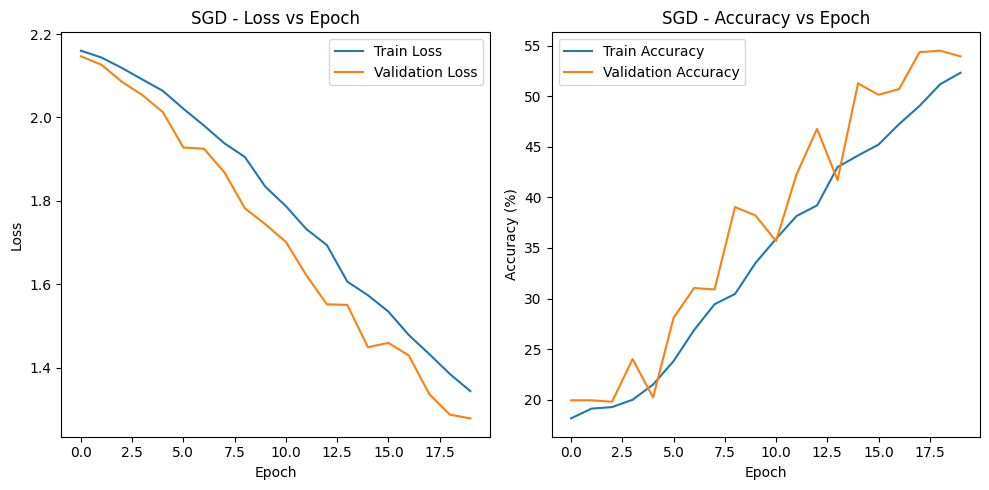


=== Evaluation Results ===
Test Accuracy: 55.46%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.44      0.53      0.48        68
      Food Organics       0.72      0.69      0.70        62
              Glass       0.67      0.71      0.69        63
              Metal       0.60      0.54      0.57       112
Miscellaneous Trash       0.16      0.07      0.10        71
              Paper       0.68      0.57      0.62        79
            Plastic       0.46      0.78      0.58       133
      Textile Trash       0.36      0.08      0.14        60
         Vegetation       0.76      0.80      0.78        66

           accuracy                           0.55       714
          macro avg       0.54      0.53      0.52       714
       weighted avg       0.54      0.55      0.53       714



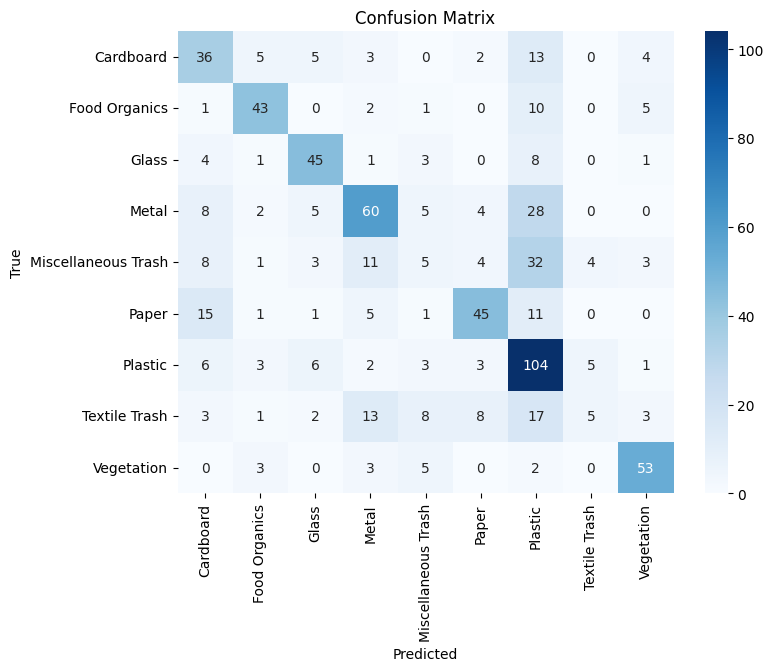


===== Training with SGD_MOMENTUM =====
Epoch [1/20] | Train Loss: 2.1375 | Val Loss: 2.0014 | Train Acc: 20.20% | Val Acc: 22.05%
Epoch [2/20] | Train Loss: 1.9954 | Val Loss: 1.9338 | Train Acc: 25.20% | Val Acc: 31.18%
Epoch [3/20] | Train Loss: 1.8740 | Val Loss: 1.7204 | Train Acc: 33.10% | Val Acc: 44.52%
Epoch [4/20] | Train Loss: 1.7178 | Val Loss: 1.6334 | Train Acc: 38.82% | Val Acc: 42.84%
Epoch [5/20] | Train Loss: 1.7056 | Val Loss: 1.5578 | Train Acc: 39.30% | Val Acc: 43.54%
Epoch [6/20] | Train Loss: 1.5421 | Val Loss: 1.4813 | Train Acc: 45.46% | Val Acc: 48.17%
Epoch [7/20] | Train Loss: 1.5177 | Val Loss: 1.5105 | Train Acc: 46.27% | Val Acc: 46.07%
Epoch [8/20] | Train Loss: 1.3644 | Val Loss: 1.3317 | Train Acc: 51.65% | Val Acc: 51.26%
Epoch [9/20] | Train Loss: 1.2963 | Val Loss: 1.2801 | Train Acc: 54.45% | Val Acc: 56.04%
Epoch [10/20] | Train Loss: 1.2020 | Val Loss: 1.3593 | Train Acc: 57.19% | Val Acc: 51.40%
Epoch [11/20] | Train Loss: 1.1127 | Val Loss: 1.

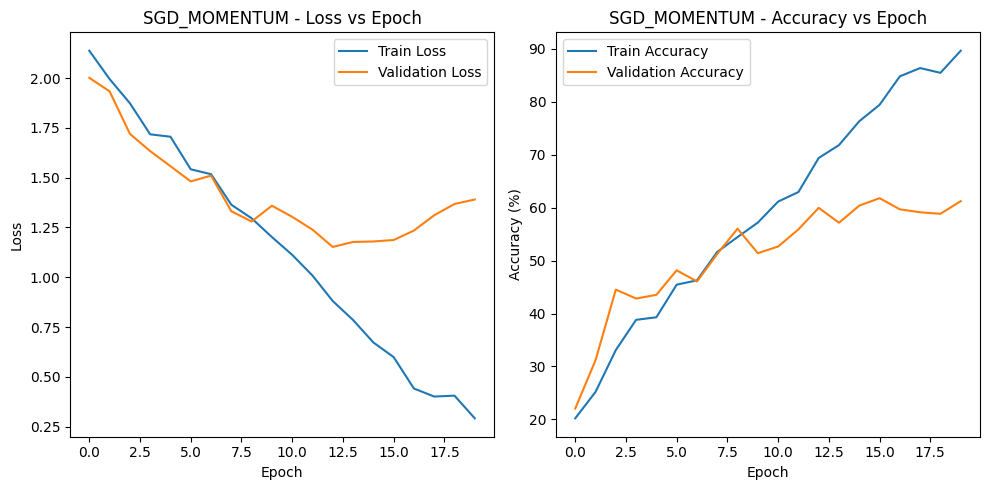


=== Evaluation Results ===
Test Accuracy: 64.43%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.51      0.44      0.47        68
      Food Organics       0.68      0.81      0.74        62
              Glass       0.77      0.75      0.76        63
              Metal       0.55      0.79      0.65       112
Miscellaneous Trash       0.54      0.38      0.45        71
              Paper       0.85      0.65      0.73        79
            Plastic       0.68      0.63      0.65       133
      Textile Trash       0.47      0.40      0.43        60
         Vegetation       0.78      0.89      0.83        66

           accuracy                           0.64       714
          macro avg       0.65      0.64      0.64       714
       weighted avg       0.65      0.64      0.64       714



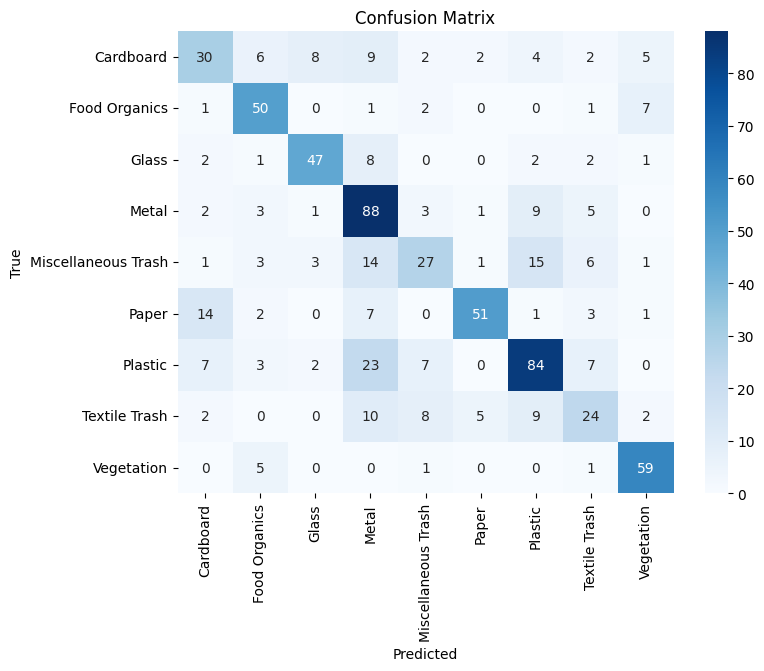

In [16]:
optimizers = ['adam', 'sgd', 'sgd_momentum']
results = {}

for opt in optimizers:
    print(f"\n===== Training with {opt.upper()} =====")
    simple_waste = SimpleWasteCNN(num_classes=NUM_CLASSES).to(device)
    lr = 0.004
    if opt=="adam":
        lr = 0.0001
    results[opt] = train_model(simple_waste, train_loader, valid_loader, num_classes=NUM_CLASSES, optimizer_name=opt, learning_rate=lr, name = "simplewaste")
    metrics = evaluate_model( model=simple_waste, dataloader=test_loader, class_names=CLASSES)



===== Training with SGD (momentum=0.5) =====
Epoch [1/20] | Train Loss: 2.1600 | Val Loss: 2.1368 | Train Acc: 17.56% | Val Acc: 19.94%
Epoch [2/20] | Train Loss: 2.1325 | Val Loss: 2.1051 | Train Acc: 19.00% | Val Acc: 25.56%
Epoch [3/20] | Train Loss: 2.0854 | Val Loss: 2.0126 | Train Acc: 21.44% | Val Acc: 24.58%
Epoch [4/20] | Train Loss: 2.0333 | Val Loss: 1.9217 | Train Acc: 24.86% | Val Acc: 30.48%
Epoch [5/20] | Train Loss: 1.9635 | Val Loss: 1.8430 | Train Acc: 27.30% | Val Acc: 35.53%
Epoch [6/20] | Train Loss: 1.9053 | Val Loss: 1.7533 | Train Acc: 30.94% | Val Acc: 40.59%
Epoch [7/20] | Train Loss: 1.8143 | Val Loss: 1.6524 | Train Acc: 34.16% | Val Acc: 38.90%
Epoch [8/20] | Train Loss: 1.7205 | Val Loss: 1.5468 | Train Acc: 37.25% | Val Acc: 45.08%
Epoch [9/20] | Train Loss: 1.6216 | Val Loss: 1.4534 | Train Acc: 41.04% | Val Acc: 48.31%
Epoch [10/20] | Train Loss: 1.5713 | Val Loss: 1.4201 | Train Acc: 43.78% | Val Acc: 49.72%
Epoch [11/20] | Train Loss: 1.4994 | Val Lo

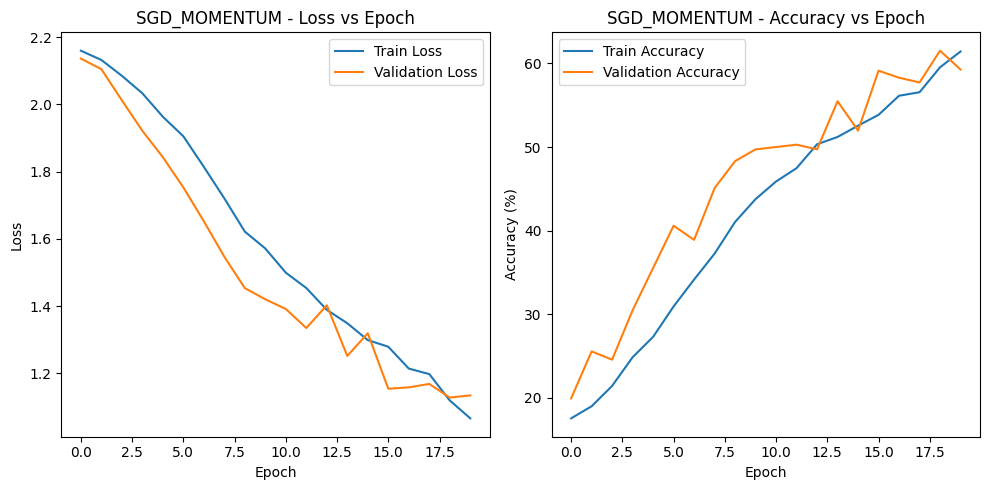


=== Evaluation Results ===
Test Accuracy: 60.08%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.49      0.63      0.55        68
      Food Organics       0.60      0.85      0.70        62
              Glass       0.90      0.71      0.80        63
              Metal       0.71      0.62      0.67       112
Miscellaneous Trash       0.25      0.32      0.28        71
              Paper       0.69      0.58      0.63        79
            Plastic       0.66      0.53      0.59       133
      Textile Trash       0.45      0.23      0.31        60
         Vegetation       0.69      0.98      0.81        66

           accuracy                           0.60       714
          macro avg       0.60      0.61      0.59       714
       weighted avg       0.62      0.60      0.60       714



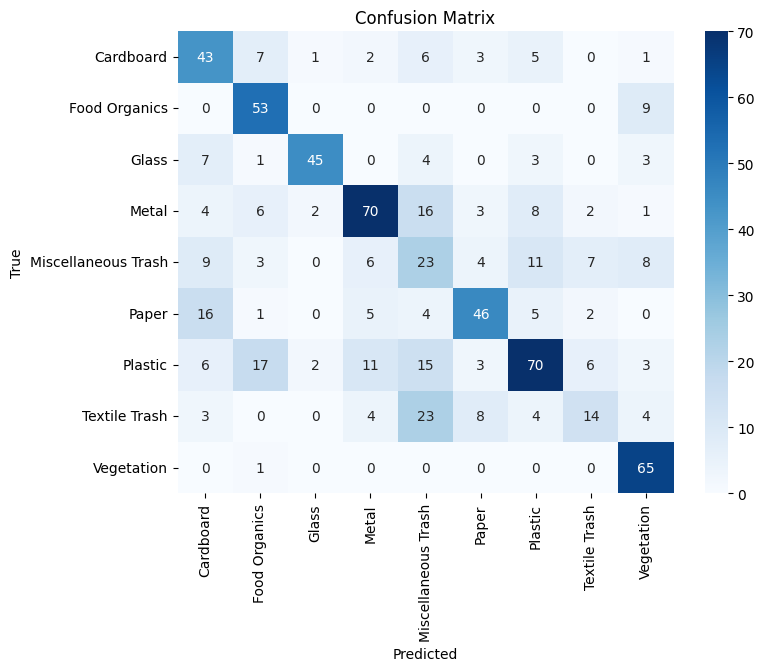


===== Training with SGD (momentum=0.7) =====
Epoch [1/20] | Train Loss: 2.1564 | Val Loss: 2.1063 | Train Acc: 18.46% | Val Acc: 19.94%
Epoch [2/20] | Train Loss: 2.0626 | Val Loss: 1.9233 | Train Acc: 22.64% | Val Acc: 24.02%
Epoch [3/20] | Train Loss: 1.9409 | Val Loss: 1.8855 | Train Acc: 29.01% | Val Acc: 28.37%
Epoch [4/20] | Train Loss: 1.8177 | Val Loss: 1.6376 | Train Acc: 32.59% | Val Acc: 41.01%
Epoch [5/20] | Train Loss: 1.7109 | Val Loss: 1.5739 | Train Acc: 37.82% | Val Acc: 43.68%
Epoch [6/20] | Train Loss: 1.6658 | Val Loss: 1.4721 | Train Acc: 40.02% | Val Acc: 46.77%
Epoch [7/20] | Train Loss: 1.5516 | Val Loss: 1.4464 | Train Acc: 43.63% | Val Acc: 47.05%
Epoch [8/20] | Train Loss: 1.4957 | Val Loss: 1.3715 | Train Acc: 46.36% | Val Acc: 49.86%
Epoch [9/20] | Train Loss: 1.4453 | Val Loss: 1.3493 | Train Acc: 48.14% | Val Acc: 48.88%
Epoch [10/20] | Train Loss: 1.4106 | Val Loss: 1.2691 | Train Acc: 48.38% | Val Acc: 54.92%
Epoch [11/20] | Train Loss: 1.3217 | Val Lo

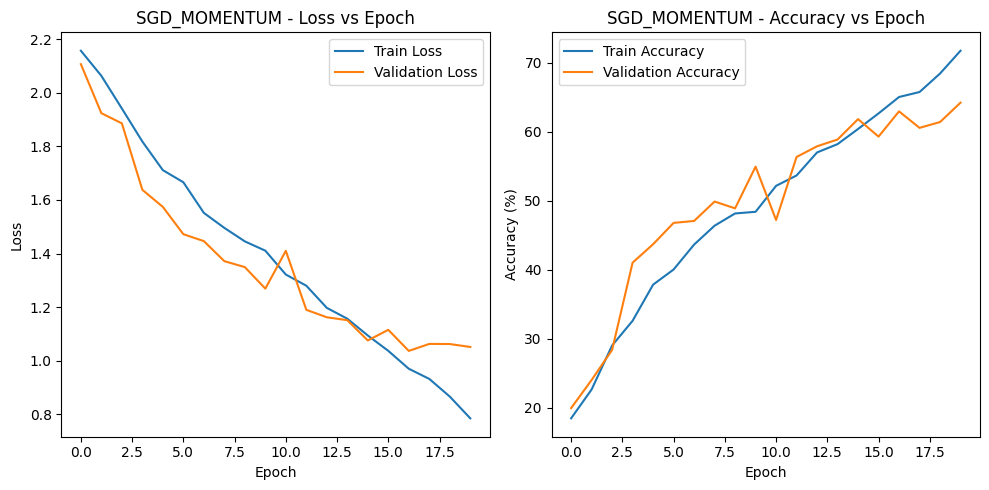


=== Evaluation Results ===
Test Accuracy: 65.27%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.63      0.57      0.60        68
      Food Organics       0.79      0.77      0.78        62
              Glass       0.97      0.62      0.76        63
              Metal       0.67      0.74      0.71       112
Miscellaneous Trash       0.37      0.27      0.31        71
              Paper       0.67      0.78      0.73        79
            Plastic       0.59      0.74      0.66       133
      Textile Trash       0.52      0.22      0.31        60
         Vegetation       0.68      0.98      0.81        66

           accuracy                           0.65       714
          macro avg       0.66      0.63      0.63       714
       weighted avg       0.65      0.65      0.64       714



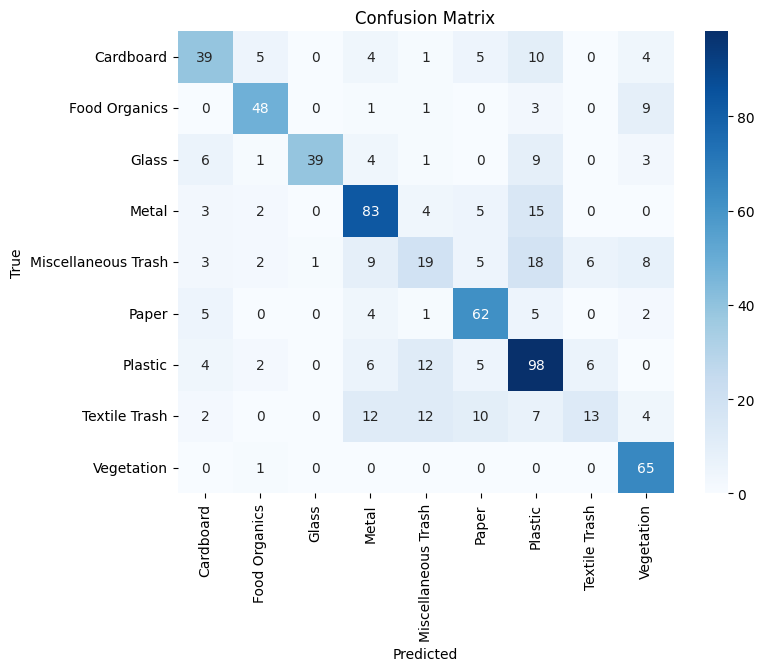


===== Training with SGD (momentum=0.9) =====
Epoch [1/20] | Train Loss: 2.0897 | Val Loss: 2.0520 | Train Acc: 21.71% | Val Acc: 21.49%
Epoch [2/20] | Train Loss: 1.9226 | Val Loss: 1.7463 | Train Acc: 28.41% | Val Acc: 35.25%
Epoch [3/20] | Train Loss: 1.7760 | Val Loss: 1.5423 | Train Acc: 36.08% | Val Acc: 41.85%
Epoch [4/20] | Train Loss: 1.6863 | Val Loss: 1.5000 | Train Acc: 39.09% | Val Acc: 45.79%
Epoch [5/20] | Train Loss: 1.5600 | Val Loss: 1.5899 | Train Acc: 44.29% | Val Acc: 42.13%
Epoch [6/20] | Train Loss: 1.4803 | Val Loss: 1.4725 | Train Acc: 46.87% | Val Acc: 48.31%
Epoch [7/20] | Train Loss: 1.3725 | Val Loss: 1.2612 | Train Acc: 50.63% | Val Acc: 56.60%
Epoch [8/20] | Train Loss: 1.2608 | Val Loss: 1.2125 | Train Acc: 54.51% | Val Acc: 55.06%
Epoch [9/20] | Train Loss: 1.1932 | Val Loss: 1.1348 | Train Acc: 57.07% | Val Acc: 59.13%
Epoch [10/20] | Train Loss: 1.0618 | Val Loss: 1.0658 | Train Acc: 62.09% | Val Acc: 60.96%
Epoch [11/20] | Train Loss: 0.9649 | Val Lo

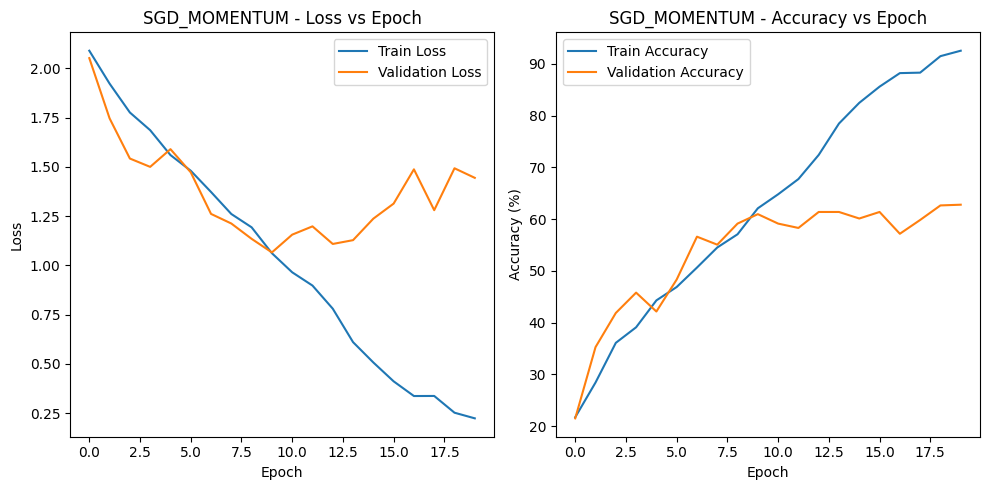


=== Evaluation Results ===
Test Accuracy: 63.87%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.58      0.50      0.54        68
      Food Organics       0.73      0.82      0.77        62
              Glass       0.86      0.68      0.76        63
              Metal       0.58      0.74      0.65       112
Miscellaneous Trash       0.44      0.44      0.44        71
              Paper       0.66      0.68      0.67        79
            Plastic       0.65      0.69      0.67       133
      Textile Trash       0.57      0.13      0.22        60
         Vegetation       0.71      0.91      0.80        66

           accuracy                           0.64       714
          macro avg       0.64      0.62      0.61       714
       weighted avg       0.64      0.64      0.62       714



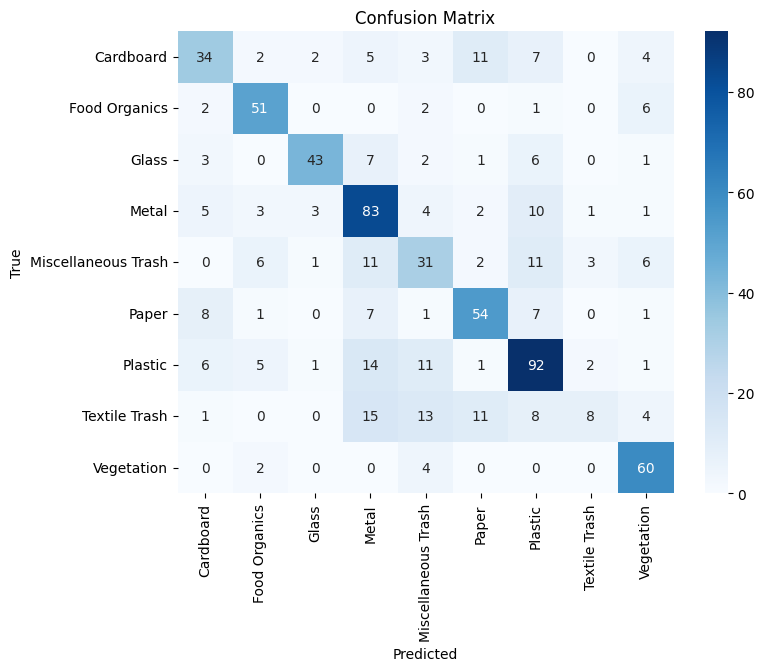

In [17]:
momentum_values = [0.5, 0.7, 0.9]

for m in momentum_values:
    print(f"\n===== Training with SGD (momentum={m}) =====")
    simple_waste = SimpleWasteCNN(num_classes=NUM_CLASSES).to(device)
    results = train_model(
        simple_waste,
        train_loader,
        valid_loader,
        num_classes=NUM_CLASSES,
        optimizer_name='sgd_momentum',
        learning_rate=0.004,
        momentum=m,
        num_epochs=20, 
        name = "simplewaste"+str(m)
    )
    metrics = evaluate_model( model=simple_waste, dataloader=test_loader, class_names=CLASSES)


In [18]:
# results_100 = {}

# for opt in optimizers:
#     print(f"\n===== Training with {opt.upper()} =====")
#     simple_waste = SimpleWasteCNN(num_classes=NUM_CLASSES)
#     lr = 0.004
#     if opt=="adam":
#         lr = 0.0001
#     results_100[opt] = train_model(simple_waste, train_loader, valid_loader, num_classes=NUM_CLASSES, optimizer_name=opt, learning_rate=lr, num_epochs=50)
#     metrics = evaluate_model( model=simple_waste, dataloader=test_loader, class_names=CLASSES)



===== Training with ADAM =====
Epoch [1/20] | Train Loss: 1.8028 | Val Loss: 1.6395 | Train Acc: 33.70% | Val Acc: 43.54%
Epoch [2/20] | Train Loss: 1.4387 | Val Loss: 1.4859 | Train Acc: 47.56% | Val Acc: 43.68%
Epoch [3/20] | Train Loss: 1.2695 | Val Loss: 0.9899 | Train Acc: 55.08% | Val Acc: 64.75%
Epoch [4/20] | Train Loss: 1.1179 | Val Loss: 1.1389 | Train Acc: 59.95% | Val Acc: 60.81%
Epoch [5/20] | Train Loss: 1.0385 | Val Loss: 0.8876 | Train Acc: 62.84% | Val Acc: 67.13%
Epoch [6/20] | Train Loss: 0.9764 | Val Loss: 0.9225 | Train Acc: 64.64% | Val Acc: 65.03%
Epoch [7/20] | Train Loss: 0.8549 | Val Loss: 0.8274 | Train Acc: 69.60% | Val Acc: 69.80%
Epoch [8/20] | Train Loss: 0.8274 | Val Loss: 0.8630 | Train Acc: 71.14% | Val Acc: 68.68%
Epoch [9/20] | Train Loss: 0.7593 | Val Loss: 0.8842 | Train Acc: 72.70% | Val Acc: 69.94%
Epoch [10/20] | Train Loss: 0.7393 | Val Loss: 0.7588 | Train Acc: 73.18% | Val Acc: 73.31%
Epoch [11/20] | Train Loss: 0.6666 | Val Loss: 0.8476 | T

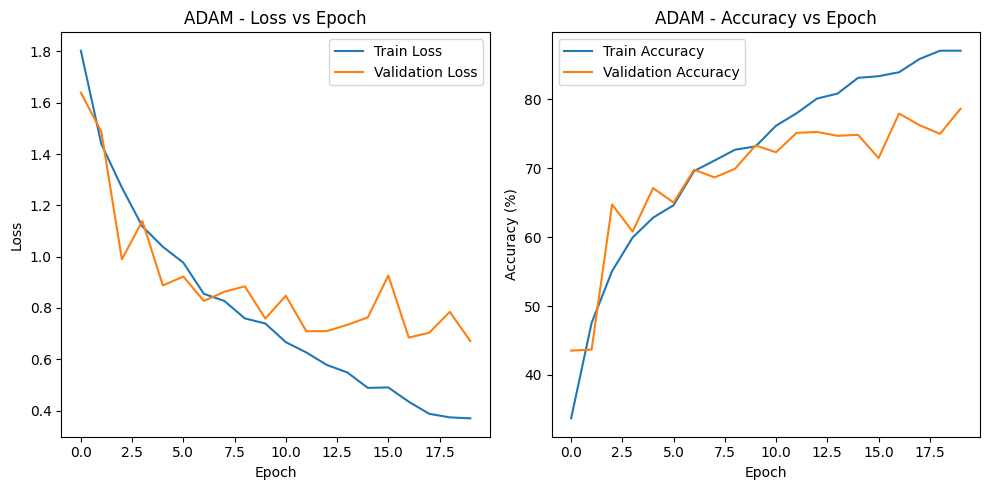


=== Evaluation Results ===
Test Accuracy: 77.73%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.90      0.66      0.76        68
      Food Organics       0.84      0.90      0.87        62
              Glass       0.84      0.84      0.84        63
              Metal       0.79      0.78      0.78       112
Miscellaneous Trash       0.69      0.54      0.60        71
              Paper       0.81      0.87      0.84        79
            Plastic       0.63      0.77      0.70       133
      Textile Trash       0.77      0.78      0.78        60
         Vegetation       0.95      0.86      0.90        66

           accuracy                           0.78       714
          macro avg       0.80      0.78      0.79       714
       weighted avg       0.79      0.78      0.78       714



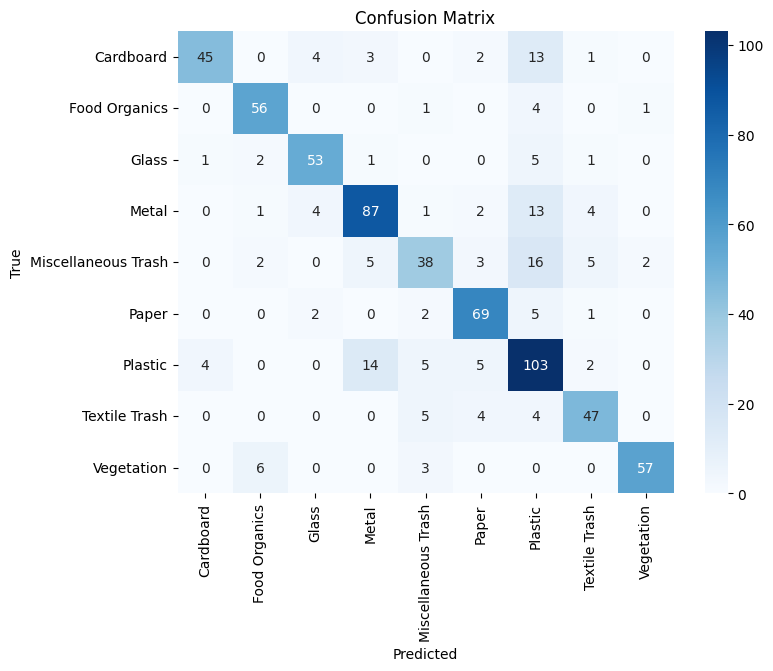


===== Training with SGD =====
Epoch [1/20] | Train Loss: 1.8732 | Val Loss: 1.6944 | Train Acc: 31.30% | Val Acc: 37.08%
Epoch [2/20] | Train Loss: 1.4897 | Val Loss: 1.3333 | Train Acc: 45.37% | Val Acc: 51.97%
Epoch [3/20] | Train Loss: 1.3249 | Val Loss: 1.4885 | Train Acc: 51.53% | Val Acc: 46.49%
Epoch [4/20] | Train Loss: 1.1704 | Val Loss: 1.1402 | Train Acc: 57.70% | Val Acc: 56.18%
Epoch [5/20] | Train Loss: 1.0792 | Val Loss: 1.1037 | Train Acc: 60.55% | Val Acc: 58.85%
Epoch [6/20] | Train Loss: 0.9916 | Val Loss: 1.5329 | Train Acc: 64.79% | Val Acc: 50.00%
Epoch [7/20] | Train Loss: 0.9513 | Val Loss: 2.0298 | Train Acc: 65.81% | Val Acc: 41.57%
Epoch [8/20] | Train Loss: 0.8840 | Val Loss: 1.3408 | Train Acc: 67.62% | Val Acc: 53.37%
Epoch [9/20] | Train Loss: 0.8392 | Val Loss: 0.9679 | Train Acc: 69.87% | Val Acc: 63.48%
Epoch [10/20] | Train Loss: 0.7568 | Val Loss: 0.8629 | Train Acc: 73.51% | Val Acc: 70.22%
Epoch [11/20] | Train Loss: 0.7337 | Val Loss: 2.1011 | Tr

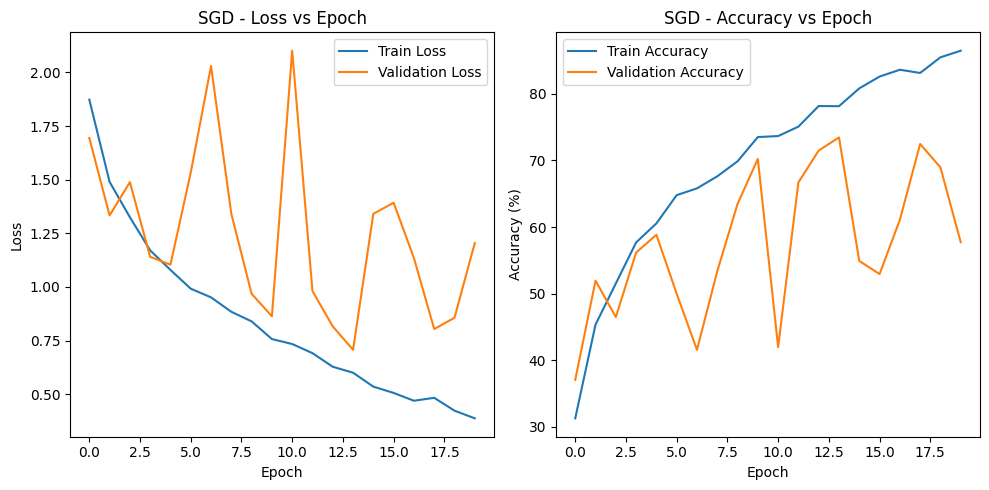


=== Evaluation Results ===
Test Accuracy: 58.40%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.64      0.40      0.49        68
      Food Organics       0.84      0.66      0.74        62
              Glass       0.58      0.60      0.59        63
              Metal       0.77      0.61      0.68       112
Miscellaneous Trash       0.47      0.13      0.20        71
              Paper       0.73      0.76      0.75        79
            Plastic       0.59      0.68      0.63       133
      Textile Trash       0.30      0.95      0.46        60
         Vegetation       1.00      0.39      0.57        66

           accuracy                           0.58       714
          macro avg       0.66      0.58      0.57       714
       weighted avg       0.66      0.58      0.58       714



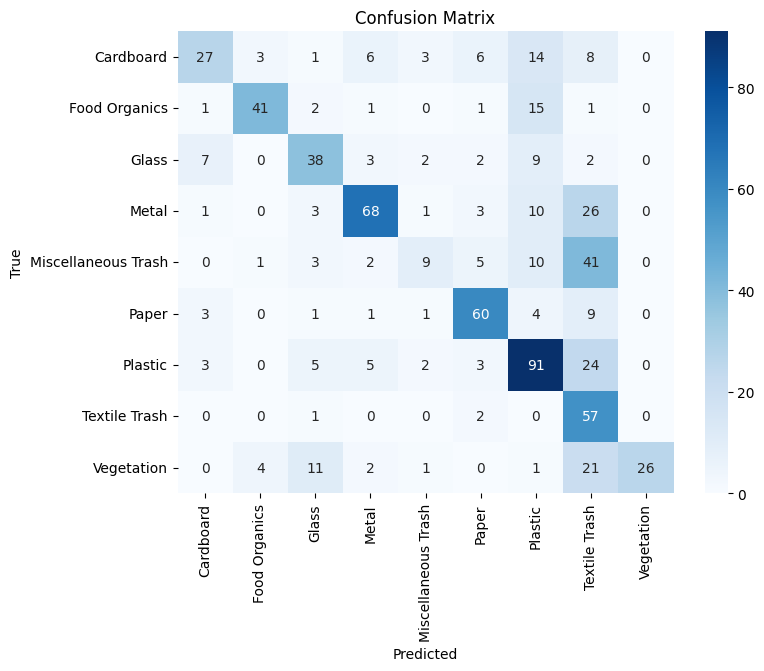


===== Training with SGD_MOMENTUM =====
Epoch [1/20] | Train Loss: 1.9024 | Val Loss: 2.4169 | Train Acc: 29.01% | Val Acc: 24.58%
Epoch [2/20] | Train Loss: 1.6359 | Val Loss: 2.0758 | Train Acc: 40.44% | Val Acc: 36.38%
Epoch [3/20] | Train Loss: 1.5331 | Val Loss: 1.6688 | Train Acc: 43.90% | Val Acc: 35.11%
Epoch [4/20] | Train Loss: 1.4397 | Val Loss: 1.7843 | Train Acc: 48.38% | Val Acc: 40.45%
Epoch [5/20] | Train Loss: 1.3622 | Val Loss: 1.2503 | Train Acc: 50.45% | Val Acc: 54.35%
Epoch [6/20] | Train Loss: 1.2998 | Val Loss: 1.7146 | Train Acc: 53.43% | Val Acc: 39.33%
Epoch [7/20] | Train Loss: 1.2766 | Val Loss: 1.2197 | Train Acc: 54.21% | Val Acc: 58.15%
Epoch [8/20] | Train Loss: 1.2114 | Val Loss: 1.2381 | Train Acc: 57.25% | Val Acc: 57.44%
Epoch [9/20] | Train Loss: 1.1589 | Val Loss: 2.1272 | Train Acc: 59.05% | Val Acc: 38.20%
Epoch [10/20] | Train Loss: 1.1487 | Val Loss: 1.5537 | Train Acc: 59.14% | Val Acc: 43.68%
Epoch [11/20] | Train Loss: 1.0794 | Val Loss: 1.

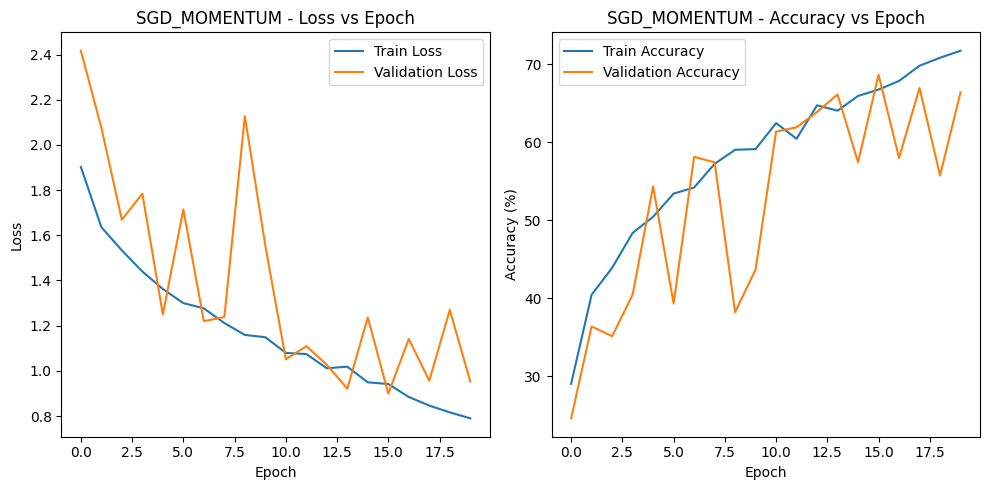


=== Evaluation Results ===
Test Accuracy: 67.65%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.62      0.60      0.61        68
      Food Organics       1.00      0.56      0.72        62
              Glass       0.68      0.83      0.75        63
              Metal       0.69      0.79      0.74       112
Miscellaneous Trash       0.47      0.35      0.40        71
              Paper       0.93      0.53      0.68        79
            Plastic       0.66      0.69      0.67       133
      Textile Trash       0.50      0.72      0.59        60
         Vegetation       0.76      0.98      0.86        66

           accuracy                           0.68       714
          macro avg       0.70      0.67      0.67       714
       weighted avg       0.70      0.68      0.67       714



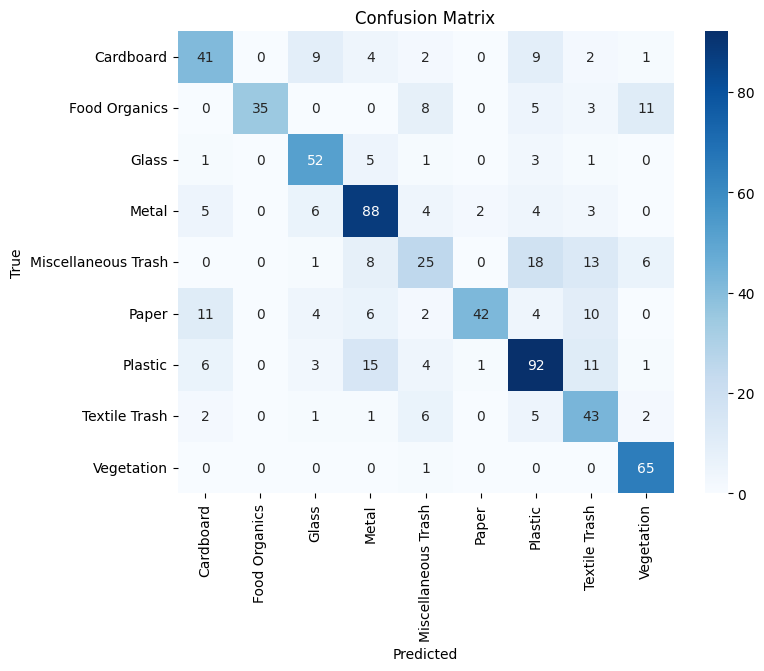

In [19]:
#lets do the similar for the more complex nerural next we created
results_1 = {}

for opt in optimizers:
    print(f"\n===== Training with {opt.upper()} =====")
    big_waste = BigWasteCNN(num_classes=NUM_CLASSES)
    lr = 0.004
    if opt=="adam":
        lr = 0.0001
    results_1[opt] = train_model(big_waste, train_loader, valid_loader, num_classes=NUM_CLASSES, optimizer_name=opt, learning_rate=lr, num_epochs=20)
    metrics = evaluate_model( model=big_waste, dataloader=test_loader, class_names=CLASSES)


We can try to compare these with a few state of the art models out there

In [20]:
# =====================================================
# Generalized ResNet builder (works for both 18 & 50)
# =====================================================
class RESNET(nn.Module):
    def __init__(self, num_classes, version=18, freeze_backbone=True):
        super(RESNET, self).__init__()

        # Select ResNet version dynamically
        if version == 18:
            self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        elif version == 50:
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            raise ValueError("Only ResNet-18 and ResNet-50 supported")

        # Optionally freeze the backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Replace the classification head
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return F.log_softmax(self.backbone(x), dim=1)


In [21]:
class ALEXNET(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True):
        super(ALEXNET, self).__init__()
        self.backbone = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

        # Optionally freeze convolutional backbone
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        # Correct classifier input = 9216
        self.backbone.classifier = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return F.log_softmax(self.backbone(x), dim=1)


In [22]:

models_zoo = {
    "resnet18": lambda: RESNET(num_classes=NUM_CLASSES, version=18, freeze_backbone=True),
    "resnet50": lambda: RESNET(num_classes=NUM_CLASSES, version=50, freeze_backbone=True),
    "alexnet":  lambda: ALEXNET(num_classes=NUM_CLASSES, freeze_backbone=True)
}



Training RESNET18 for 20 epochs (Adam)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Epoch [1/20] | Train Loss: 1.4960 | Val Loss: 1.0086 | Train Acc: 51.08% | Val Acc: 70.08%
Epoch [2/20] | Train Loss: 0.9838 | Val Loss: 0.8030 | Train Acc: 69.75% | Val Acc: 74.30%
Epoch [3/20] | Train Loss: 0.8078 | Val Loss: 0.6883 | Train Acc: 75.68% | Val Acc: 76.40%
Epoch [4/20] | Train Loss: 0.7138 | Val Loss: 0.6460 | Train Acc: 77.87% | Val Acc: 78.23%
Epoch [5/20] | Train Loss: 0.6278 | Val Loss: 0.6003 | Train Acc: 80.52% | Val Acc: 78.65%
Epoch [6/20] | Train Loss: 0.5734 | Val Loss: 0.5786 | Train Acc: 81.54% | Val Acc: 80.34%
Epoch [7/20] | Train Loss: 0.5240 | Val Loss: 0.5507 | Train Acc: 84.06% | Val Acc: 81.46%
Epoch [8/20] | Train Loss: 0.4798 | Val Loss: 0.5447 | Train Acc: 85.63% | Val Acc: 81.60%
Epoch [9/20] | Train Loss: 0.4453 | Val Loss: 0.5332 | Train Acc: 87.28% | Val Acc: 81.18%
Epoch [10/20] | Train Loss: 0.4114 | Val Loss: 0.5255 | Train Acc: 88.18% | Val Acc: 82.16%
Epoch [11/20] | Train Loss: 0.4028 | Val Loss: 0.5163 | Train Acc: 87.64% | Val Acc: 82.4

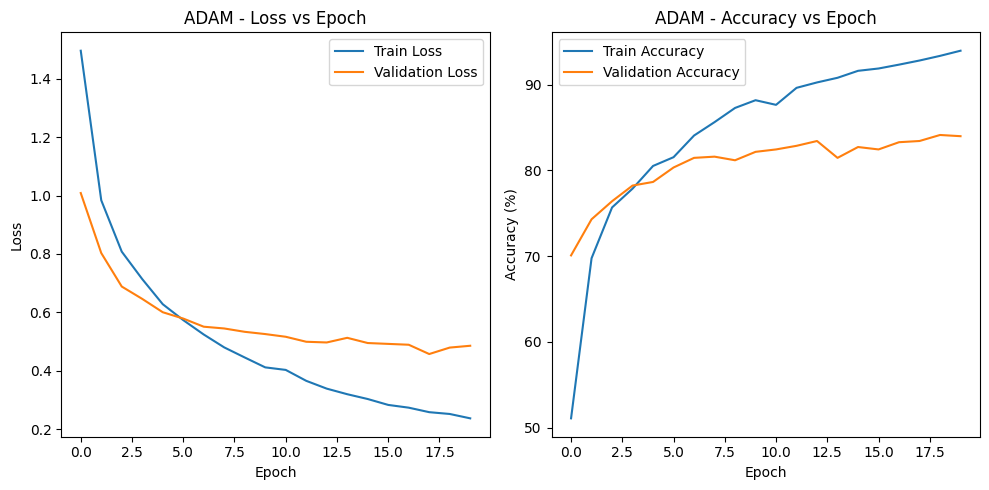


=== Evaluation Results ===
Test Accuracy: 83.75%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.82      0.81      0.81        68
      Food Organics       0.89      0.87      0.88        62
              Glass       0.98      0.75      0.85        63
              Metal       0.78      0.92      0.84       112
Miscellaneous Trash       0.77      0.69      0.73        71
              Paper       0.84      0.87      0.86        79
            Plastic       0.79      0.80      0.80       133
      Textile Trash       0.88      0.87      0.87        60
         Vegetation       0.94      0.94      0.94        66

           accuracy                           0.84       714
          macro avg       0.85      0.84      0.84       714
       weighted avg       0.84      0.84      0.84       714



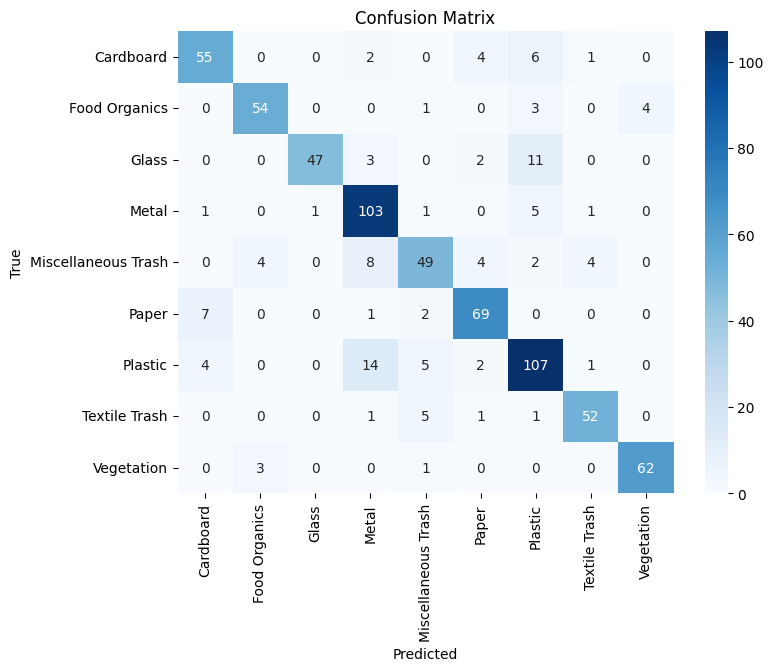


Training RESNET50 for 20 epochs (Adam)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


Epoch [1/20] | Train Loss: 1.2003 | Val Loss: 0.7555 | Train Acc: 62.42% | Val Acc: 76.54%
Epoch [2/20] | Train Loss: 0.7091 | Val Loss: 0.5633 | Train Acc: 79.98% | Val Acc: 84.27%
Epoch [3/20] | Train Loss: 0.5521 | Val Loss: 0.5162 | Train Acc: 84.22% | Val Acc: 84.41%
Epoch [4/20] | Train Loss: 0.4657 | Val Loss: 0.4640 | Train Acc: 86.89% | Val Acc: 85.25%
Epoch [5/20] | Train Loss: 0.3800 | Val Loss: 0.4242 | Train Acc: 89.90% | Val Acc: 87.78%
Epoch [6/20] | Train Loss: 0.3220 | Val Loss: 0.4120 | Train Acc: 91.22% | Val Acc: 87.08%
Epoch [7/20] | Train Loss: 0.2830 | Val Loss: 0.3825 | Train Acc: 92.81% | Val Acc: 87.36%
Epoch [8/20] | Train Loss: 0.2439 | Val Loss: 0.3995 | Train Acc: 94.02% | Val Acc: 87.78%
Epoch [9/20] | Train Loss: 0.2166 | Val Loss: 0.3723 | Train Acc: 94.62% | Val Acc: 90.03%
Epoch [10/20] | Train Loss: 0.1860 | Val Loss: 0.3884 | Train Acc: 95.79% | Val Acc: 88.06%
Epoch [11/20] | Train Loss: 0.1828 | Val Loss: 0.3828 | Train Acc: 95.31% | Val Acc: 88.9

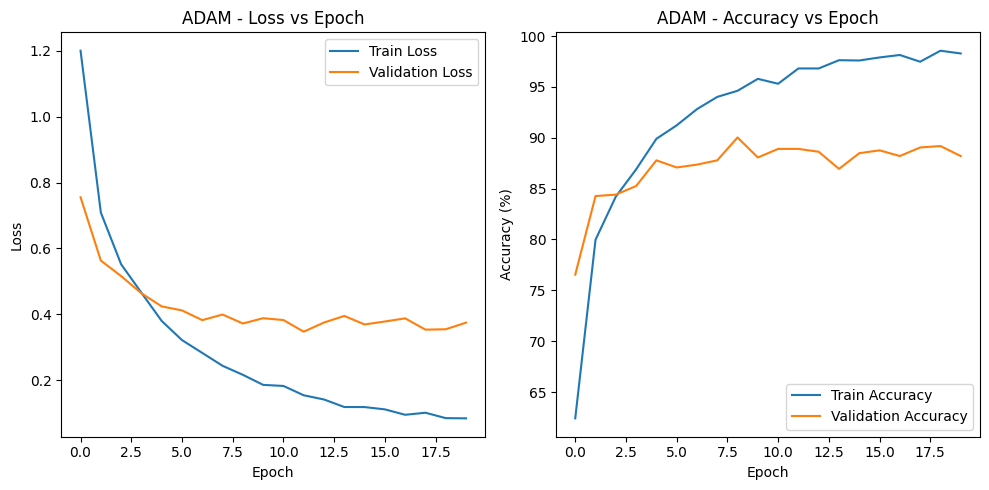


=== Evaluation Results ===
Test Accuracy: 87.68%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.93      0.75      0.83        68
      Food Organics       0.91      0.95      0.93        62
              Glass       0.91      0.95      0.93        63
              Metal       0.85      0.94      0.89       112
Miscellaneous Trash       0.88      0.79      0.83        71
              Paper       0.78      0.92      0.84        79
            Plastic       0.84      0.83      0.83       133
      Textile Trash       0.94      0.83      0.88        60
         Vegetation       0.98      0.94      0.96        66

           accuracy                           0.88       714
          macro avg       0.89      0.88      0.88       714
       weighted avg       0.88      0.88      0.88       714



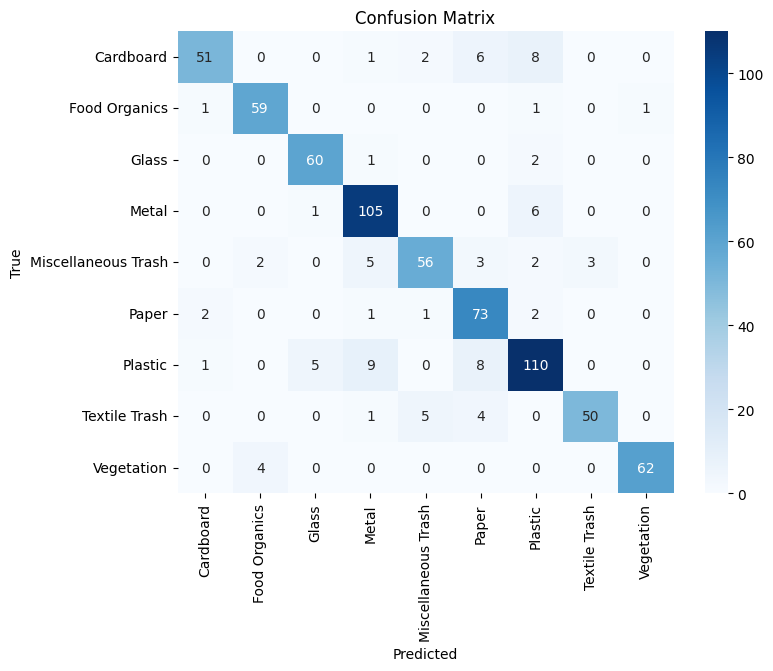


Training ALEXNET for 20 epochs (Adam)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 200MB/s]


Epoch [1/20] | Train Loss: 1.4020 | Val Loss: 0.9425 | Train Acc: 50.12% | Val Acc: 68.82%
Epoch [2/20] | Train Loss: 0.9845 | Val Loss: 0.7989 | Train Acc: 65.90% | Val Acc: 71.35%
Epoch [3/20] | Train Loss: 0.7858 | Val Loss: 0.7370 | Train Acc: 73.09% | Val Acc: 75.00%
Epoch [4/20] | Train Loss: 0.6682 | Val Loss: 0.6995 | Train Acc: 77.21% | Val Acc: 75.56%
Epoch [5/20] | Train Loss: 0.5426 | Val Loss: 0.6508 | Train Acc: 81.99% | Val Acc: 75.98%
Epoch [6/20] | Train Loss: 0.4369 | Val Loss: 0.6562 | Train Acc: 85.60% | Val Acc: 75.98%
Epoch [7/20] | Train Loss: 0.3777 | Val Loss: 0.7210 | Train Acc: 87.76% | Val Acc: 73.74%
Epoch [8/20] | Train Loss: 0.3468 | Val Loss: 0.6711 | Train Acc: 88.09% | Val Acc: 75.56%
Epoch [9/20] | Train Loss: 0.2879 | Val Loss: 0.6510 | Train Acc: 90.23% | Val Acc: 78.51%
Epoch [10/20] | Train Loss: 0.2293 | Val Loss: 0.6875 | Train Acc: 92.30% | Val Acc: 77.81%
Epoch [11/20] | Train Loss: 0.1915 | Val Loss: 0.6829 | Train Acc: 93.93% | Val Acc: 77.6

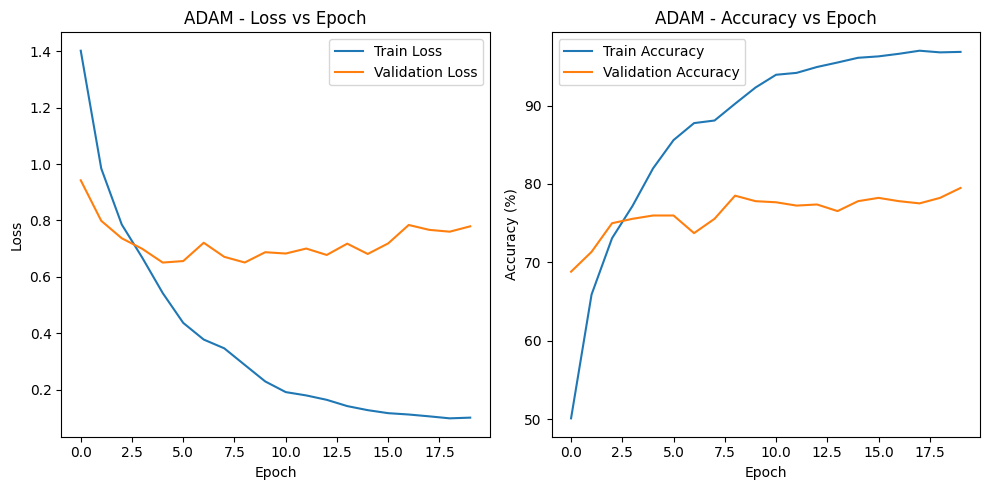


=== Evaluation Results ===
Test Accuracy: 79.13%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.82      0.74      0.78        68
      Food Organics       0.84      0.95      0.89        62
              Glass       0.89      0.89      0.89        63
              Metal       0.75      0.84      0.79       112
Miscellaneous Trash       0.75      0.58      0.65        71
              Paper       0.73      0.84      0.78        79
            Plastic       0.74      0.75      0.75       133
      Textile Trash       0.78      0.67      0.72        60
         Vegetation       0.94      0.89      0.91        66

           accuracy                           0.79       714
          macro avg       0.80      0.79      0.80       714
       weighted avg       0.79      0.79      0.79       714



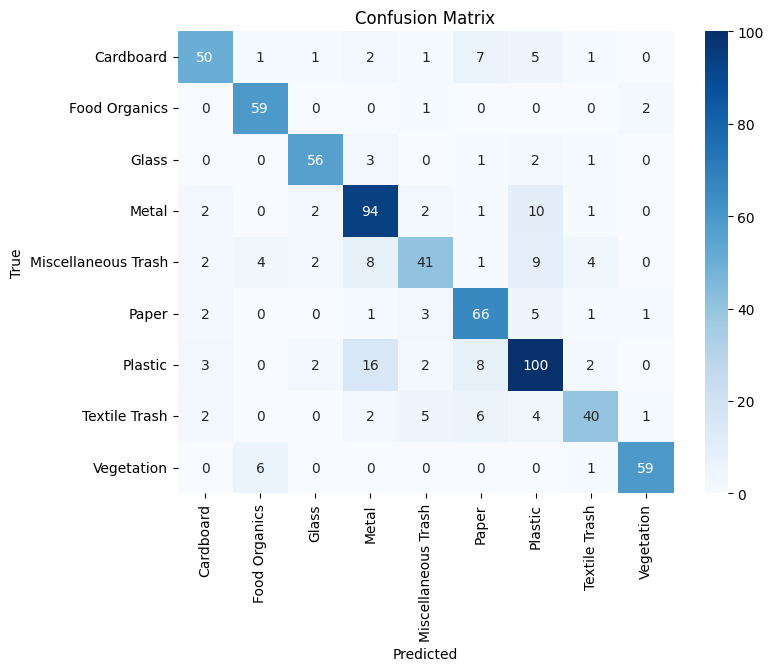

In [23]:
# ================================================
# Training all models with Adam for 20 and 80 epochs
# ================================================

results_state_art = {}

# --- First round: 20 epochs ---
for name, model_fn in models_zoo.items():
    print(f"\n{'='*50}\nTraining {name.upper()} for 20 epochs (Adam)\n{'='*50}")
    model = model_fn() 
    results_state_art[f"{name}_adam_20"] = train_model(
        model_class=model,   # passing the model instance
        train_loader=train_loader,
        val_loader=valid_loader,
        num_classes=NUM_CLASSES,
        optimizer_name="adam",
        learning_rate=0.0001,
        num_epochs=20
    )
    metrics = evaluate_model( model=model, dataloader=test_loader, class_names=CLASSES)



Training RESNET18 for 20 epochs (Adam)
Epoch [1/20] | Train Loss: 1.6172 | Val Loss: 1.1245 | Train Acc: 45.82% | Val Acc: 66.01%
Epoch [2/20] | Train Loss: 1.1117 | Val Loss: 0.9064 | Train Acc: 65.09% | Val Acc: 70.51%
Epoch [3/20] | Train Loss: 0.9454 | Val Loss: 0.7750 | Train Acc: 70.32% | Val Acc: 74.16%
Epoch [4/20] | Train Loss: 0.8387 | Val Loss: 0.7120 | Train Acc: 73.48% | Val Acc: 75.28%
Epoch [5/20] | Train Loss: 0.7589 | Val Loss: 0.6713 | Train Acc: 75.14% | Val Acc: 76.83%
Epoch [6/20] | Train Loss: 0.6912 | Val Loss: 0.6237 | Train Acc: 78.05% | Val Acc: 78.79%
Epoch [7/20] | Train Loss: 0.6715 | Val Loss: 0.5974 | Train Acc: 77.90% | Val Acc: 78.79%
Epoch [8/20] | Train Loss: 0.6220 | Val Loss: 0.5825 | Train Acc: 79.34% | Val Acc: 80.62%
Epoch [9/20] | Train Loss: 0.5833 | Val Loss: 0.5753 | Train Acc: 81.21% | Val Acc: 79.35%
Epoch [10/20] | Train Loss: 0.5416 | Val Loss: 0.5469 | Train Acc: 82.38% | Val Acc: 81.32%
Epoch [11/20] | Train Loss: 0.5231 | Val Loss: 0.

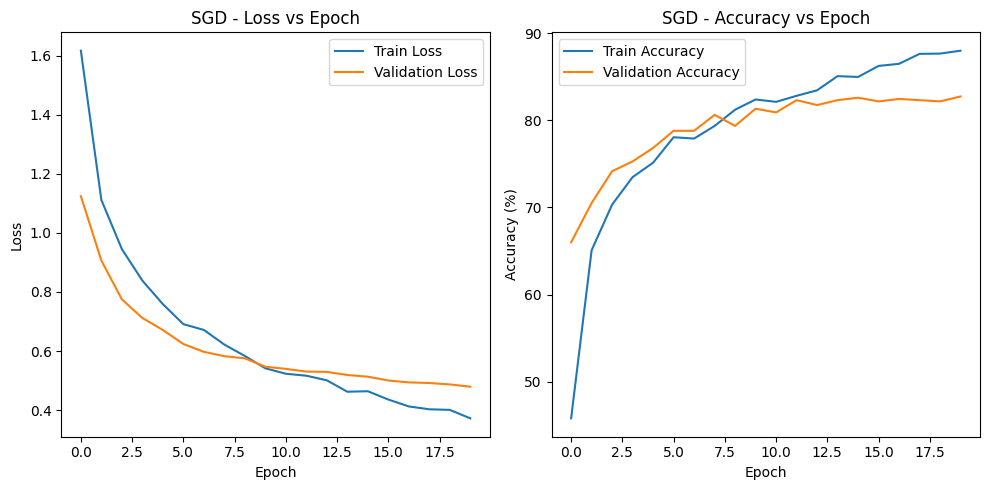


=== Evaluation Results ===
Test Accuracy: 82.49%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.80      0.78      0.79        68
      Food Organics       0.84      0.87      0.86        62
              Glass       0.91      0.83      0.87        63
              Metal       0.82      0.88      0.85       112
Miscellaneous Trash       0.74      0.76      0.75        71
              Paper       0.83      0.85      0.84        79
            Plastic       0.79      0.77      0.78       133
      Textile Trash       0.84      0.80      0.82        60
         Vegetation       0.90      0.92      0.91        66

           accuracy                           0.82       714
          macro avg       0.83      0.83      0.83       714
       weighted avg       0.83      0.82      0.82       714



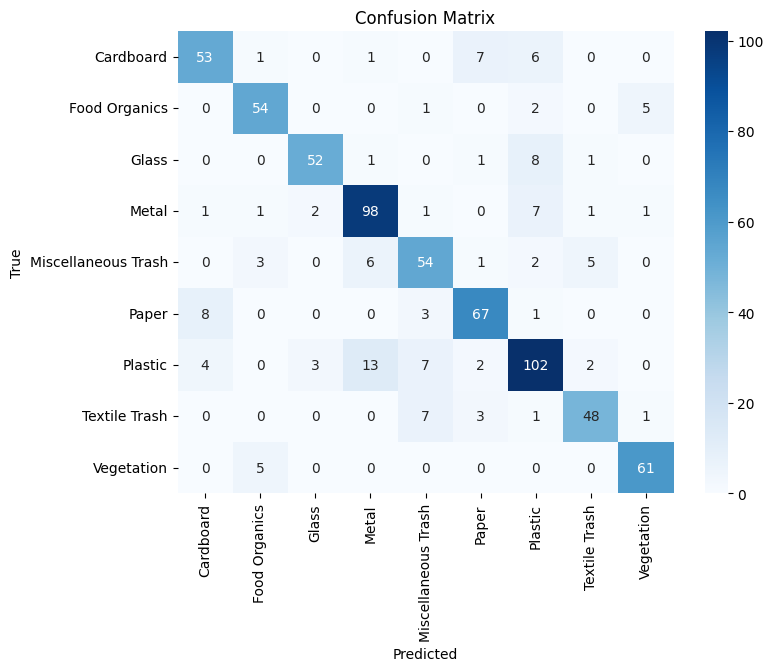


Training RESNET50 for 20 epochs (Adam)
Epoch [1/20] | Train Loss: 1.4100 | Val Loss: 0.8916 | Train Acc: 54.57% | Val Acc: 73.88%
Epoch [2/20] | Train Loss: 0.8904 | Val Loss: 0.7082 | Train Acc: 72.61% | Val Acc: 77.95%
Epoch [3/20] | Train Loss: 0.7101 | Val Loss: 0.5969 | Train Acc: 78.35% | Val Acc: 81.18%
Epoch [4/20] | Train Loss: 0.6120 | Val Loss: 0.6265 | Train Acc: 80.49% | Val Acc: 80.90%
Epoch [5/20] | Train Loss: 0.5602 | Val Loss: 0.5234 | Train Acc: 82.20% | Val Acc: 82.72%
Epoch [6/20] | Train Loss: 0.4931 | Val Loss: 0.4951 | Train Acc: 84.49% | Val Acc: 83.15%
Epoch [7/20] | Train Loss: 0.4322 | Val Loss: 0.4824 | Train Acc: 86.98% | Val Acc: 84.13%
Epoch [8/20] | Train Loss: 0.3985 | Val Loss: 0.4271 | Train Acc: 88.33% | Val Acc: 85.25%
Epoch [9/20] | Train Loss: 0.3827 | Val Loss: 0.4120 | Train Acc: 88.09% | Val Acc: 86.66%
Epoch [10/20] | Train Loss: 0.3485 | Val Loss: 0.4290 | Train Acc: 89.96% | Val Acc: 86.52%
Epoch [11/20] | Train Loss: 0.3372 | Val Loss: 0.

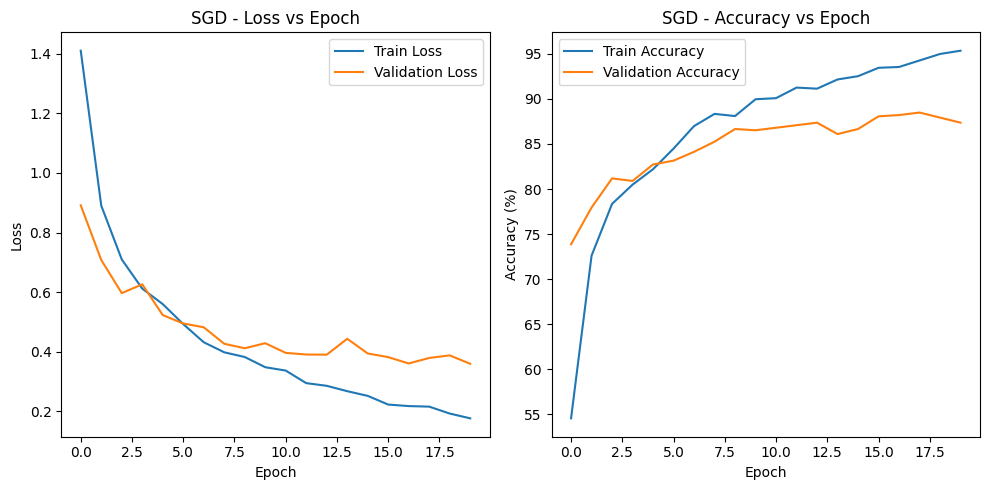


=== Evaluation Results ===
Test Accuracy: 88.52%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.95      0.79      0.86        68
      Food Organics       0.89      0.90      0.90        62
              Glass       0.92      0.92      0.92        63
              Metal       0.84      0.95      0.89       112
Miscellaneous Trash       0.86      0.83      0.84        71
              Paper       0.86      0.92      0.89        79
            Plastic       0.86      0.86      0.86       133
      Textile Trash       0.96      0.83      0.89        60
         Vegetation       0.94      0.94      0.94        66

           accuracy                           0.89       714
          macro avg       0.90      0.88      0.89       714
       weighted avg       0.89      0.89      0.88       714



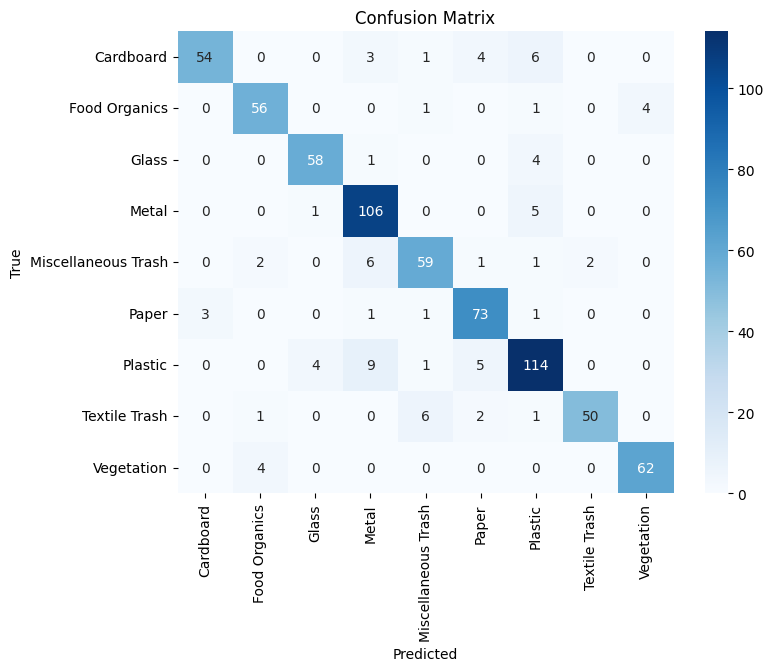


Training ALEXNET for 20 epochs (Adam)
Epoch [1/20] | Train Loss: 1.5363 | Val Loss: 1.1245 | Train Acc: 44.23% | Val Acc: 61.52%
Epoch [2/20] | Train Loss: 1.1485 | Val Loss: 0.9544 | Train Acc: 61.18% | Val Acc: 67.42%
Epoch [3/20] | Train Loss: 0.9736 | Val Loss: 0.8441 | Train Acc: 66.60% | Val Acc: 71.49%
Epoch [4/20] | Train Loss: 0.8614 | Val Loss: 0.7599 | Train Acc: 70.38% | Val Acc: 74.44%
Epoch [5/20] | Train Loss: 0.7503 | Val Loss: 0.7273 | Train Acc: 74.38% | Val Acc: 75.14%
Epoch [6/20] | Train Loss: 0.6455 | Val Loss: 0.6837 | Train Acc: 78.41% | Val Acc: 76.54%
Epoch [7/20] | Train Loss: 0.6015 | Val Loss: 0.6762 | Train Acc: 79.98% | Val Acc: 76.12%
Epoch [8/20] | Train Loss: 0.5395 | Val Loss: 0.6880 | Train Acc: 81.39% | Val Acc: 75.00%
Epoch [9/20] | Train Loss: 0.4756 | Val Loss: 0.6858 | Train Acc: 83.85% | Val Acc: 75.98%
Epoch [10/20] | Train Loss: 0.4300 | Val Loss: 0.6688 | Train Acc: 85.03% | Val Acc: 75.84%
Epoch [11/20] | Train Loss: 0.3782 | Val Loss: 0.7

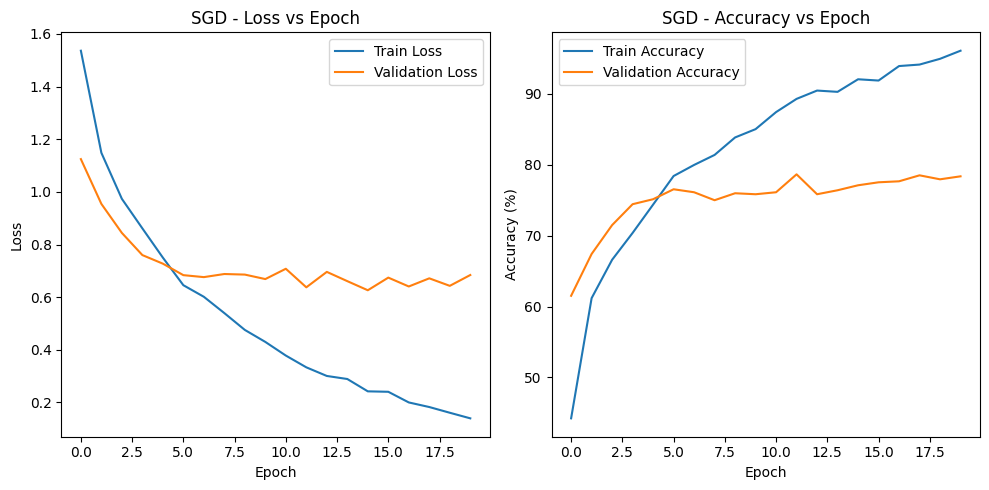


=== Evaluation Results ===
Test Accuracy: 78.15%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.80      0.72      0.76        68
      Food Organics       0.89      0.95      0.92        62
              Glass       0.86      0.87      0.87        63
              Metal       0.74      0.86      0.79       112
Miscellaneous Trash       0.84      0.51      0.63        71
              Paper       0.69      0.80      0.74        79
            Plastic       0.74      0.72      0.73       133
      Textile Trash       0.72      0.68      0.70        60
         Vegetation       0.88      0.95      0.91        66

           accuracy                           0.78       714
          macro avg       0.80      0.79      0.78       714
       weighted avg       0.78      0.78      0.78       714



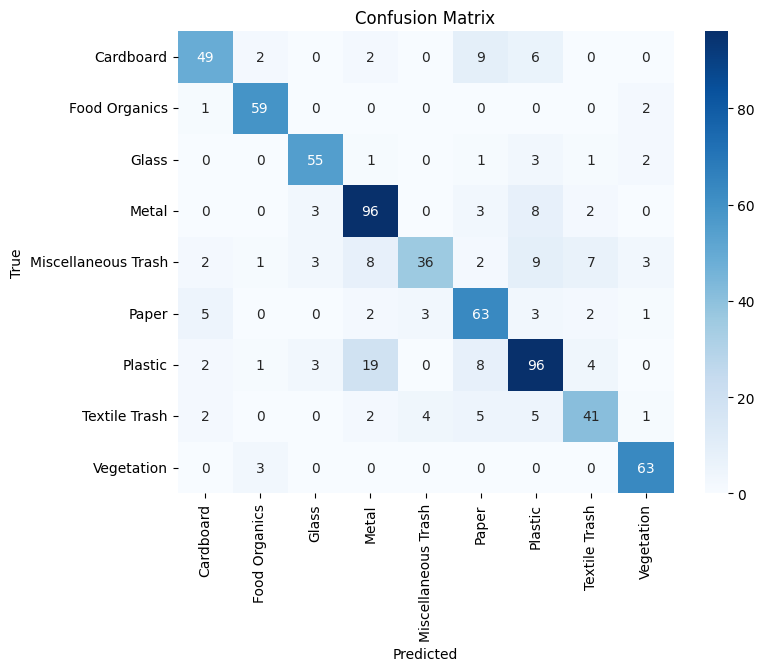

In [24]:
# ================================================
# Training all models with Adam for 20 and 80 epochs
# ================================================

results_state_art_sgd = {}

# --- First round: 20 epochs ---
for name, model_fn in models_zoo.items():
    print(f"\n{'='*50}\nTraining {name.upper()} for 20 epochs (Adam)\n{'='*50}")
    model = model_fn() 
    results_state_art[f"{name}_adam_20"] = train_model(
        model_class=model,   # passing the model instance
        train_loader=train_loader,
        val_loader=valid_loader,
        num_classes=NUM_CLASSES,
        optimizer_name="sgd",
        learning_rate=0.004,
        num_epochs=20
    )
    metrics = evaluate_model( model=model, dataloader=test_loader, class_names=CLASSES)



Training RESNET18 for 20 epochs (Adam)
Epoch [1/20] | Train Loss: 1.0714 | Val Loss: 0.6455 | Train Acc: 62.93% | Val Acc: 74.72%
Epoch [2/20] | Train Loss: 0.6263 | Val Loss: 0.5283 | Train Acc: 77.78% | Val Acc: 81.88%
Epoch [3/20] | Train Loss: 0.4915 | Val Loss: 0.5308 | Train Acc: 82.86% | Val Acc: 81.74%
Epoch [4/20] | Train Loss: 0.3974 | Val Loss: 0.5046 | Train Acc: 86.02% | Val Acc: 82.72%
Epoch [5/20] | Train Loss: 0.3185 | Val Loss: 0.5336 | Train Acc: 88.88% | Val Acc: 81.74%
Epoch [6/20] | Train Loss: 0.3041 | Val Loss: 0.4710 | Train Acc: 89.54% | Val Acc: 84.69%
Epoch [7/20] | Train Loss: 0.2649 | Val Loss: 0.4830 | Train Acc: 90.77% | Val Acc: 84.27%
Epoch [8/20] | Train Loss: 0.2385 | Val Loss: 0.4921 | Train Acc: 91.64% | Val Acc: 85.11%
Epoch [9/20] | Train Loss: 0.2044 | Val Loss: 0.4740 | Train Acc: 93.39% | Val Acc: 84.83%
Epoch [10/20] | Train Loss: 0.1732 | Val Loss: 0.5058 | Train Acc: 94.38% | Val Acc: 84.83%
Epoch [11/20] | Train Loss: 0.1679 | Val Loss: 0.

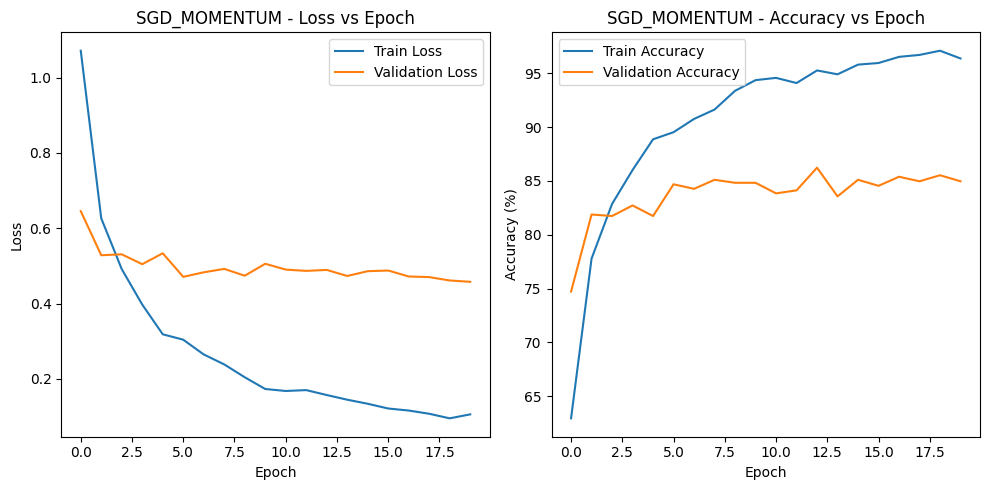


=== Evaluation Results ===
Test Accuracy: 86.69%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.88      0.82      0.85        68
      Food Organics       0.85      0.90      0.88        62
              Glass       0.93      0.86      0.89        63
              Metal       0.86      0.88      0.87       112
Miscellaneous Trash       0.90      0.73      0.81        71
              Paper       0.89      0.91      0.90        79
            Plastic       0.83      0.86      0.84       133
      Textile Trash       0.82      0.92      0.87        60
         Vegetation       0.91      0.92      0.92        66

           accuracy                           0.87       714
          macro avg       0.87      0.87      0.87       714
       weighted avg       0.87      0.87      0.87       714



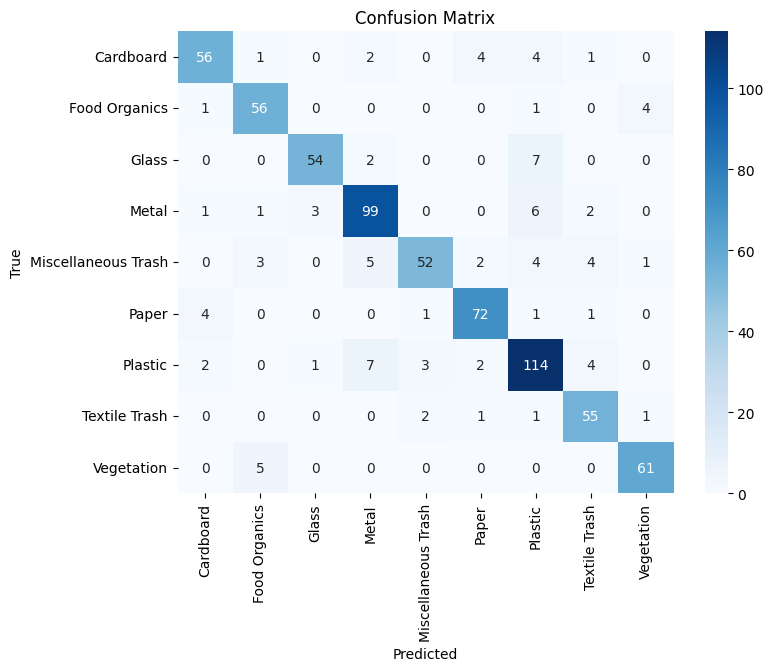


Training RESNET50 for 20 epochs (Adam)
Epoch [1/20] | Train Loss: 0.9111 | Val Loss: 0.5281 | Train Acc: 67.50% | Val Acc: 83.57%
Epoch [2/20] | Train Loss: 0.5034 | Val Loss: 0.5317 | Train Acc: 82.74% | Val Acc: 83.99%
Epoch [3/20] | Train Loss: 0.3658 | Val Loss: 0.4129 | Train Acc: 87.28% | Val Acc: 86.24%
Epoch [4/20] | Train Loss: 0.2810 | Val Loss: 0.4314 | Train Acc: 90.65% | Val Acc: 86.66%
Epoch [5/20] | Train Loss: 0.2253 | Val Loss: 0.4141 | Train Acc: 92.30% | Val Acc: 86.38%
Epoch [6/20] | Train Loss: 0.1877 | Val Loss: 0.4478 | Train Acc: 93.66% | Val Acc: 85.39%
Epoch [7/20] | Train Loss: 0.1878 | Val Loss: 0.3964 | Train Acc: 93.08% | Val Acc: 87.36%
Epoch [8/20] | Train Loss: 0.1346 | Val Loss: 0.3971 | Train Acc: 95.34% | Val Acc: 88.48%
Epoch [9/20] | Train Loss: 0.1371 | Val Loss: 0.3736 | Train Acc: 95.37% | Val Acc: 88.62%
Epoch [10/20] | Train Loss: 0.1235 | Val Loss: 0.4230 | Train Acc: 96.00% | Val Acc: 87.64%
Epoch [11/20] | Train Loss: 0.1134 | Val Loss: 0.

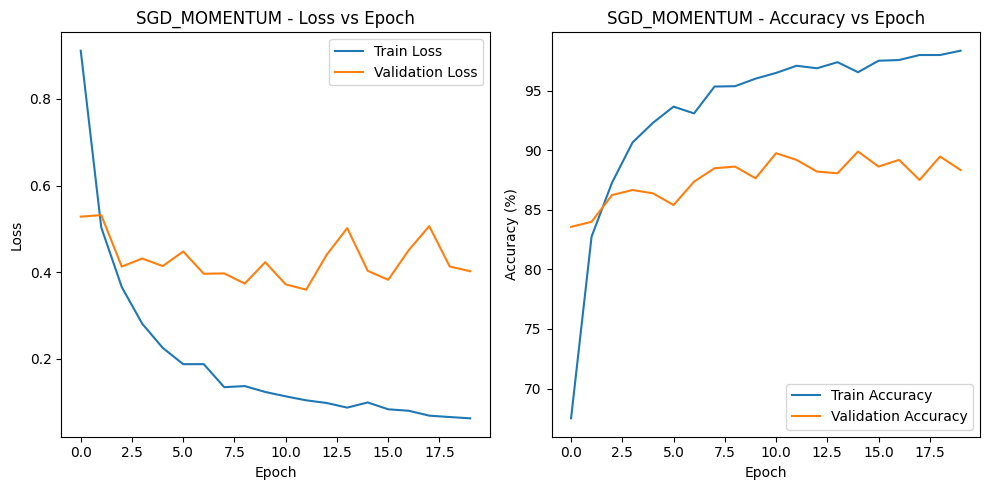


=== Evaluation Results ===
Test Accuracy: 87.96%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.92      0.79      0.85        68
      Food Organics       0.88      0.95      0.91        62
              Glass       0.92      0.87      0.89        63
              Metal       0.86      0.91      0.89       112
Miscellaneous Trash       0.79      0.83      0.81        71
              Paper       0.89      0.91      0.90        79
            Plastic       0.83      0.86      0.85       133
      Textile Trash       0.96      0.85      0.90        60
         Vegetation       0.97      0.92      0.95        66

           accuracy                           0.88       714
          macro avg       0.89      0.88      0.88       714
       weighted avg       0.88      0.88      0.88       714



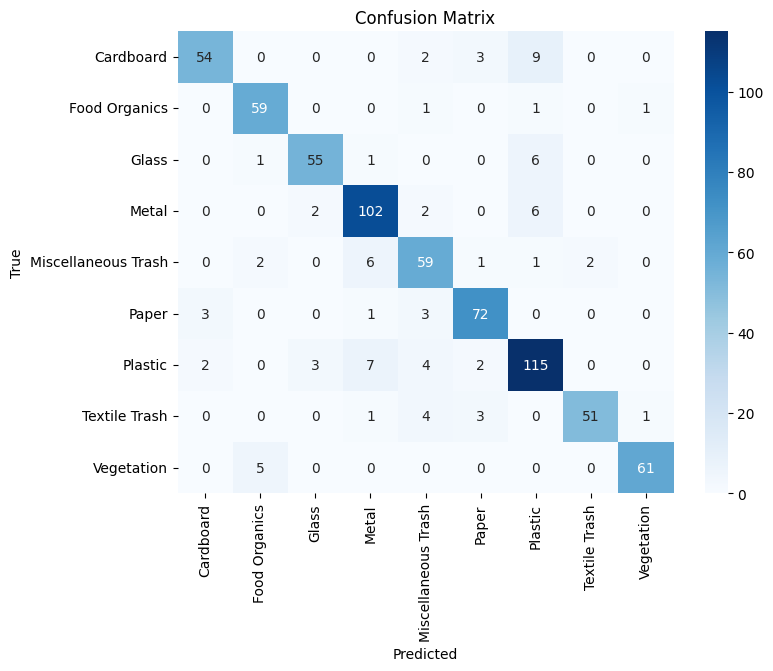


Training ALEXNET for 20 epochs (Adam)
Epoch [1/20] | Train Loss: 1.7506 | Val Loss: 1.1642 | Train Acc: 40.47% | Val Acc: 59.69%
Epoch [2/20] | Train Loss: 1.4627 | Val Loss: 1.2942 | Train Acc: 51.26% | Val Acc: 54.63%
Epoch [3/20] | Train Loss: 1.2579 | Val Loss: 0.9361 | Train Acc: 57.67% | Val Acc: 66.99%
Epoch [4/20] | Train Loss: 1.1581 | Val Loss: 0.7995 | Train Acc: 62.54% | Val Acc: 71.49%
Epoch [5/20] | Train Loss: 1.0525 | Val Loss: 0.8223 | Train Acc: 65.39% | Val Acc: 70.93%
Epoch [6/20] | Train Loss: 0.9562 | Val Loss: 0.8069 | Train Acc: 67.50% | Val Acc: 72.61%
Epoch [7/20] | Train Loss: 0.8690 | Val Loss: 0.7863 | Train Acc: 71.35% | Val Acc: 74.02%
Epoch [8/20] | Train Loss: 0.7971 | Val Loss: 0.7407 | Train Acc: 73.12% | Val Acc: 74.02%
Epoch [9/20] | Train Loss: 0.7452 | Val Loss: 0.7627 | Train Acc: 74.65% | Val Acc: 73.74%
Epoch [10/20] | Train Loss: 0.6696 | Val Loss: 0.8547 | Train Acc: 76.61% | Val Acc: 72.61%
Epoch [11/20] | Train Loss: 0.6606 | Val Loss: 0.7

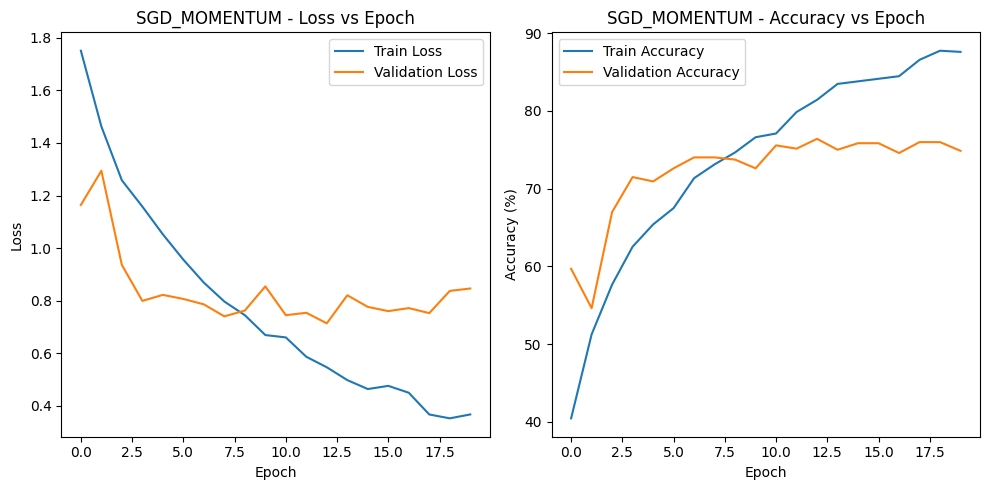


=== Evaluation Results ===
Test Accuracy: 77.31%

Detailed Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.74      0.81      0.77        68
      Food Organics       0.93      0.82      0.87        62
              Glass       0.86      0.86      0.86        63
              Metal       0.75      0.88      0.81       112
Miscellaneous Trash       0.65      0.55      0.60        71
              Paper       0.76      0.73      0.75        79
            Plastic       0.78      0.70      0.74       133
      Textile Trash       0.70      0.70      0.70        60
         Vegetation       0.81      0.94      0.87        66

           accuracy                           0.77       714
          macro avg       0.78      0.78      0.77       714
       weighted avg       0.77      0.77      0.77       714



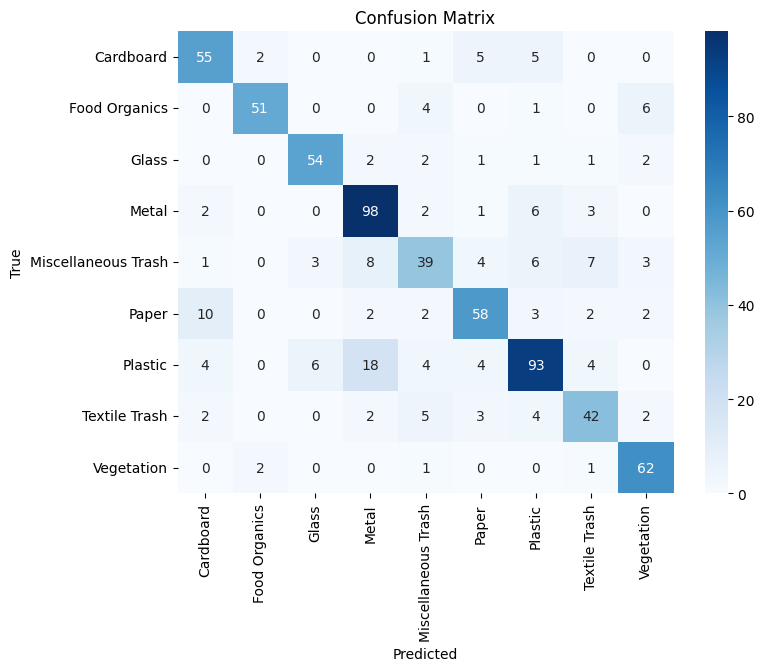

In [25]:
results_state_art_sgd_momentum = {}

# --- First round: 20 epochs ---
for name, model_fn in models_zoo.items():
    print(f"\n{'='*50}\nTraining {name.upper()} for 20 epochs (Adam)\n{'='*50}")
    model = model_fn() 
    results_state_art[f"{name}_adam_20"] = train_model(
        model_class=model,   # passing the model instance
        train_loader=train_loader,
        val_loader=valid_loader,
        num_classes=NUM_CLASSES,
        optimizer_name="sgd_momentum",
        learning_rate=0.004,
        num_epochs=20
    )
    metrics = evaluate_model( model=model, dataloader=test_loader, class_names=CLASSES)


In [26]:

# # --- Second round: 80 epochs ---
# for name, model_fn in models_zoo.items():
#     print(f"\n{'='*50}\nTraining {name.upper()} for 20 epochs (Adam)\n{'='*50}")
#     model = model_fn() 
#     results_state_art[f"{name}_adam_20"] = train_model(
#         model_class=model,   # passing the model instance
#         train_loader=train_loader,
#         val_loader=valid_loader,
#         num_classes=NUM_CLASSES,
#         optimizer_name="adam",
#         learning_rate=0.0001,
#         num_epochs=80
#     )
#     metrics = evaluate_model( model=model, dataloader=test_loader, class_names=CLASSES)


| Metric             | What to look for                                          | Ideal pattern                            |
| ------------------ | --------------------------------------------------------- | ---------------------------------------- |
| **Train loss**     | Should steadily decrease                                  | Smooth downward trend                    |
| **Val loss**       | Should decrease, then flatten                             | Early stopping should trigger soon after |
| **Val accuracy**   | Should rise and then plateau                              | Stop when it plateaus                    |
| **Early stopping** | Should trigger when val loss increases for several epochs | You have this working perfectly         |
